In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/ROIData/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.mha')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.mha')))

num_classes = 3
num_slices = 48

num_workers_te = 0
batch_size_te = 1

output_dir = "."
model_filename_base = "BAMC_PTX_ROI_3DUNet-4Class.best_model.vfold"

num_images = len(all_images)
print(num_images)
num_folds = 10

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 2
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 2
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

110
88 14 8
88 8 14
87 14 9
91 9 10
92 10 8
93 8 9
85 9 16
87 16 7
88 7 15
81 15 14


In [3]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape
print(train_shape)

roi_size = list(train_shape)
roi_size[0] = num_slices
roi_size = tuple(roi_size)

print(roi_size)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ToTensord(keys=["image", "label"]),
    ]
)

(61, 96, 96)
(48, 96, 96)


In [4]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

In [5]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

In [66]:
def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    loss_file = os.path.join(output_dir, model_filename_base+"_loss_"+str(vfold_num)+".npy")
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = os.path.join(output_dir, model_filename_base+"_val_dice_"+str(vfold_num)+".npy")
        metric_values = np.load(metric_file)
    
        plt.figure("train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Epoch Average Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.subplot(1, 2, 2)
        plt.title("Val Mean Dice")
        x = [2 * (i + 1) for i in range(len(metric_values))]
        y = metric_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.show()
    
    model_file = os.path.join(output_dir, model_filename_base+'_'+str(vfold_num)+'.pth')
    if os.path.exists(model_file):
        model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=num_classes,
            channels=(16, 32, 64),
            strides=(2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count2 = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:4]!=prevfname[:4]:
                        print(prevfname[:4], "Counts per class = ", count1, count2)
                        if count1 > 0:
                            print("  Winner = NOT Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                        else:
                            print("  Winner = Sliding")
                            if prevfname[3] == 'n':
                                incorrect += 1
                            else:
                                correct += 1
                        print()
                        print()
                        count1 = 0
                        count2 = 0
 
                    #(maxZ, maxZI) = torch.max(test_outputs, dim=4)
                    #maxZ = torch.mean(test_outputs, dim=4)
                    maxZ = torch.sum(test_outputs, dim=4)
                    mC = np.zeros([maxZ.shape[2],maxZ.shape[3]])
                    mC /= test_outputs.shape[4]
                    for y in range(maxZ.shape[2]):
                        for x in range(maxZ.shape[3]):
                            m1 = 0
                            m2 = 0
                            m1C = 0
                            for c in range(num_classes):
                                if np.count_nonzero(test_data["label"][j, 0, y, x, :])>0:
                                    if maxZ[j,c,y,x] > m2:
                                        m2 = maxZ[j,c,y,x]
                                    if maxZ[j,c,y,x] > m1:
                                        m2 = m1
                                        m1 = maxZ[j,c,y,x]
                                        m1C = c
                            if m1>0.95 and m1-m2>0.4:
                                mC[y,x] = m1C
                    slice_count1 = np.count_nonzero(mC==1)
                    slice_count2 = np.count_nonzero(mC==2)
                    if slice_count1>2*slice_count2:
                        count1 += 1
                    else:
                        count2 += 1

                    print(fname)

                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 0, :, :, 10]
                    plt.imshow(tmpV, cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    tmpV = test_data["label"][j, 0, :, :, 10]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    plt.imshow(tmpV)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    #tmpV = torch.argmax(test_outputs, dim=1).detach().cpu()[j, :, :, 10]
                    #tmpV[0,0]=1
                    #tmpV[0,1]=2
                    #tmpV[0,2]=3
                    mC[0,0]=1
                    mC[0,1]=2
                    mC[0,2]=3
                    plt.imshow(mC)
                    #plt.imshow(tmpV)
                    plt.show()
                    for c in range(num_classes):
                        arrimg = test_outputs.detach().cpu()[j,c,:,:,:]
                        itkimg = itk.GetImageFromArray(arrimg)
                        filename = "test_f"+str(b)+"_i"+str(j)+"_c"+str(c)+".mha"
                        itk.imwrite(itkimg, filename)
                    i += 1
                    
            print(prevfname[:4], "Counts per class = ", count1, count2)
            if count1 > 0:
                print("  Winner = NOT Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
            else:
                print("  Winner = Sliding")
                if prevfname[3] == 'n':
                    incorrect += 1
                else:
                    correct += 1
            print()
            print()
    return correct, incorrect

VFOLD = 0 of 10


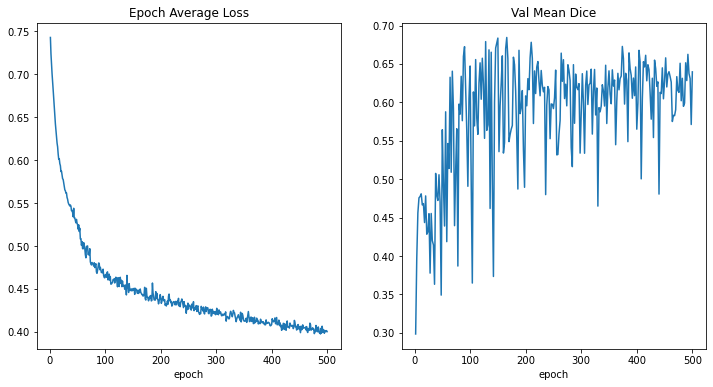

236s_iimage_1139765223418_CLEAN_ClassS_195-291.roi.mha


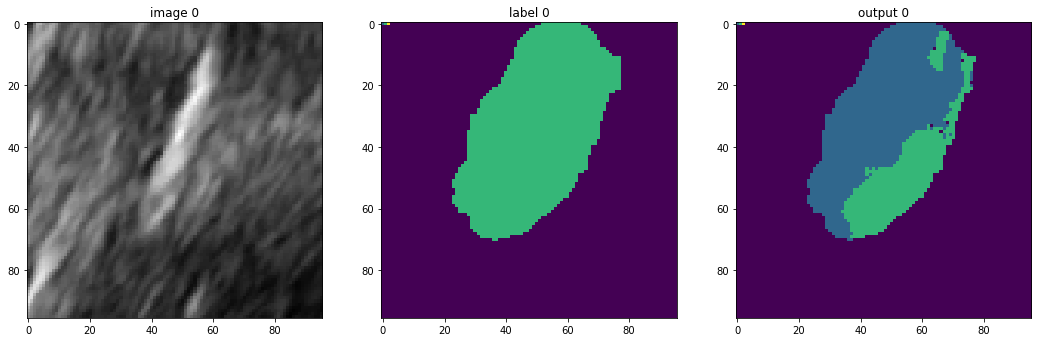

236s_iimage_1139765223418_CLEAN_ClassS_90-186.roi.mha


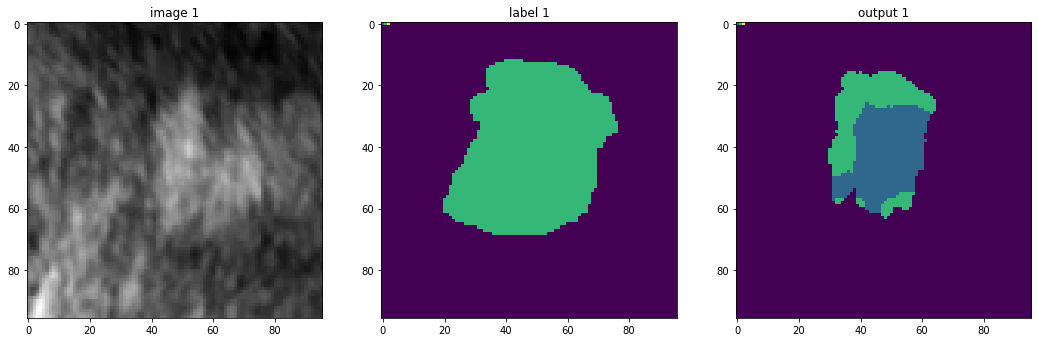

236s_iimage_1327616672148_clean_ClassS_189-285.roi.mha


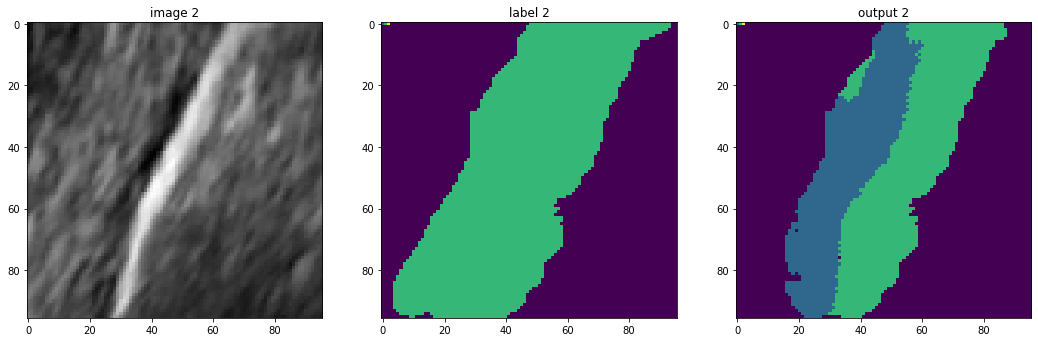

236s Counts per class =  1 2
  Winner = NOT Sliding


237s_iimage_24164968068436_CLEAN_ClassS_191-287.roi.mha


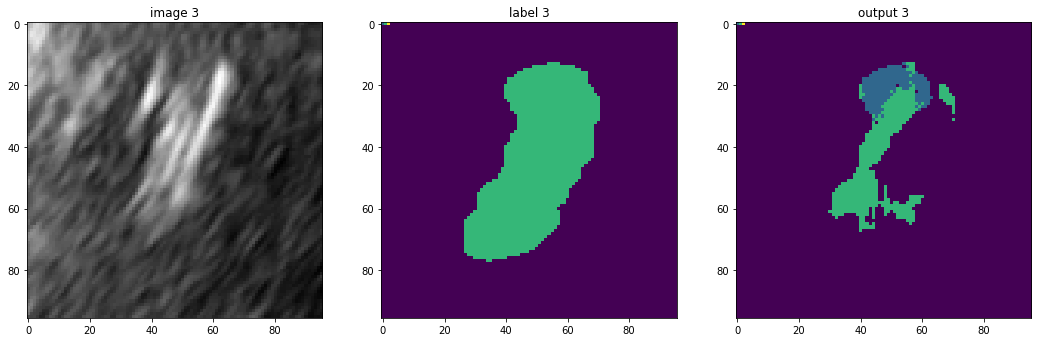

237s_iimage_24164968068436_CLEAN_ClassS_70-166.roi.mha


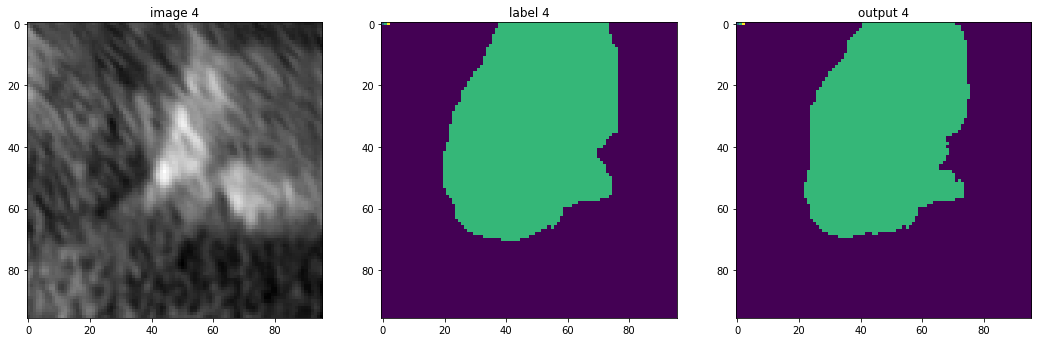

237s Counts per class =  0 2
  Winner = Sliding


247ns_image_2734882394424_CLEAN_ClassN_111-207.roi.mha


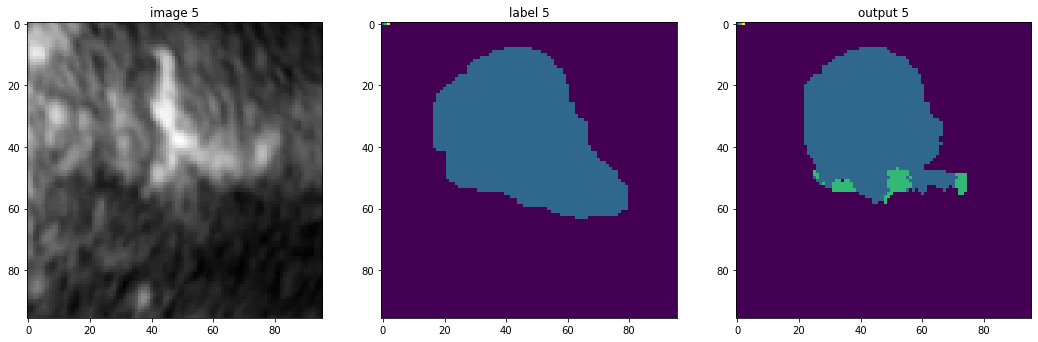

247ns_image_2743083265515_CLEAN_ClassN_151-247.roi.mha


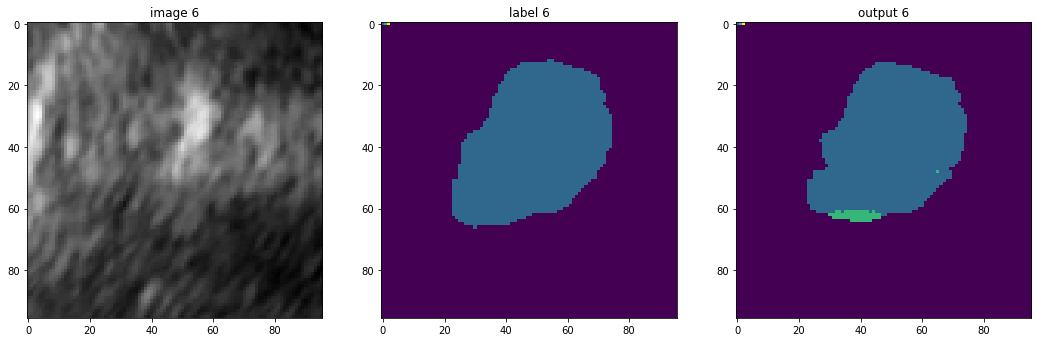

247ns_image_2743083265515_CLEAN_ClassN_76-172.roi.mha


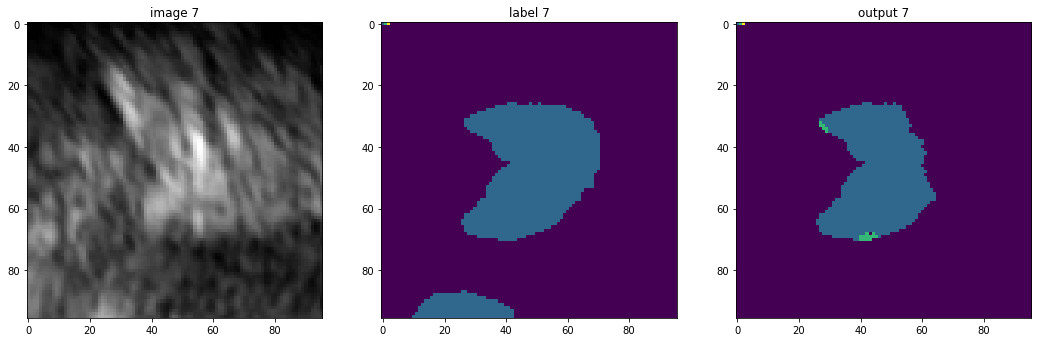

247n Counts per class =  3 0
  Winner = NOT Sliding


VFOLD = 1 of 10


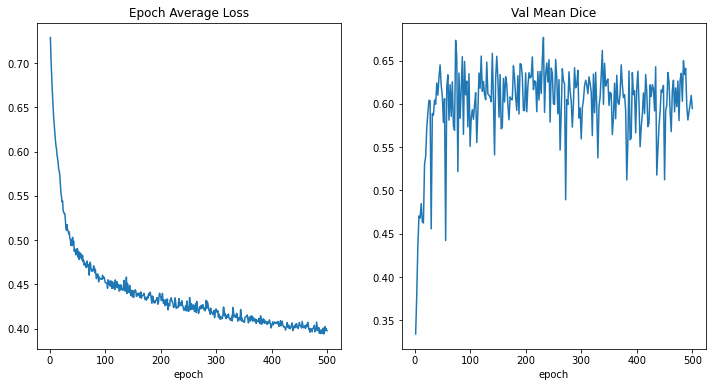

004s_iimage_73815992352100_clean_ClassS_201-297.roi.mha


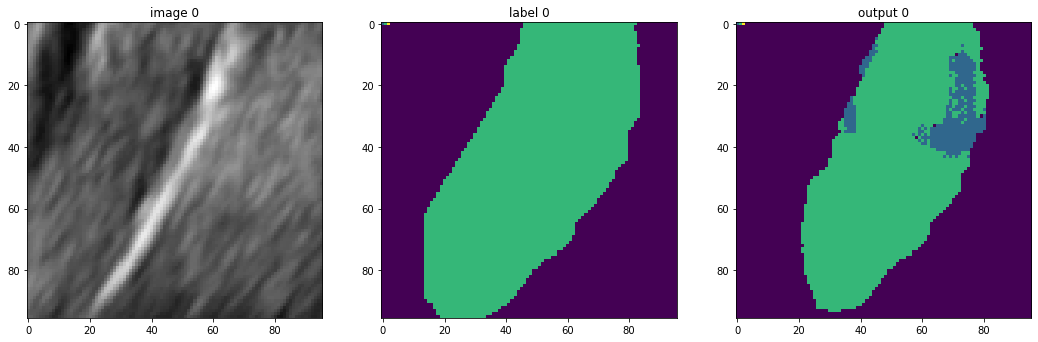

004s_iimage_73815992352100_clean_ClassS_86-182.roi.mha


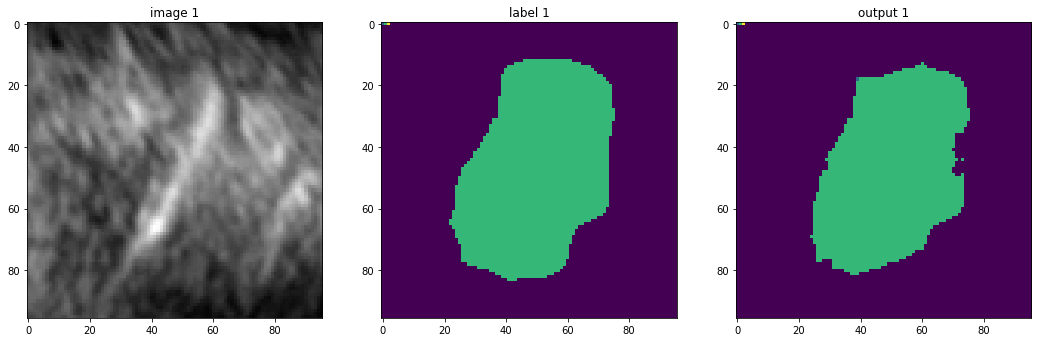

004s_iimage_74132233134844_clean_ClassS_0-96.roi.mha


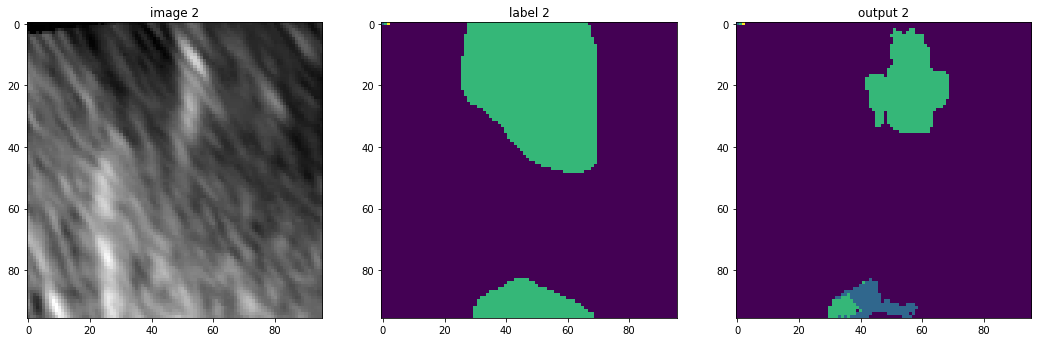

004s_iimage_74132233134844_clean_ClassS_112-208.roi.mha


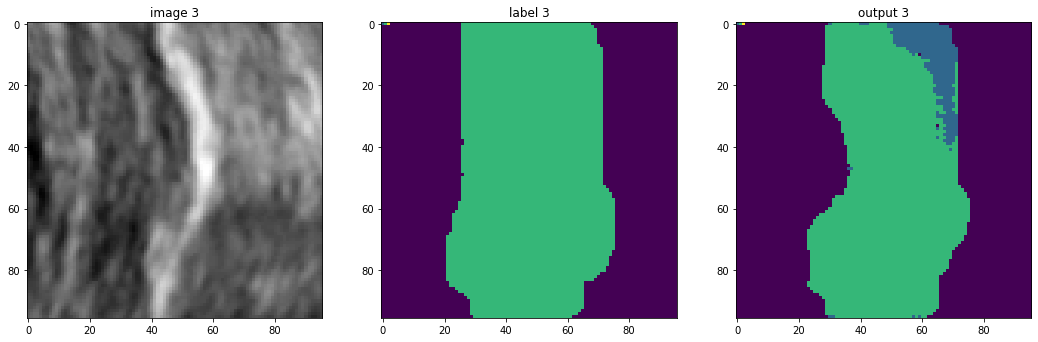

004s_iimage_74132233134844_clean_ClassS_224-320.roi.mha


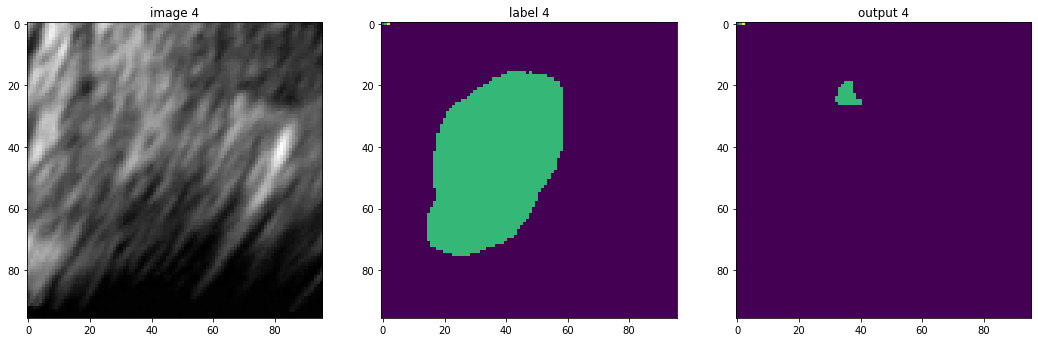

004s Counts per class =  0 5
  Winner = Sliding


025ns_Image_262499828648_clean_ClassN_150-246.roi.mha


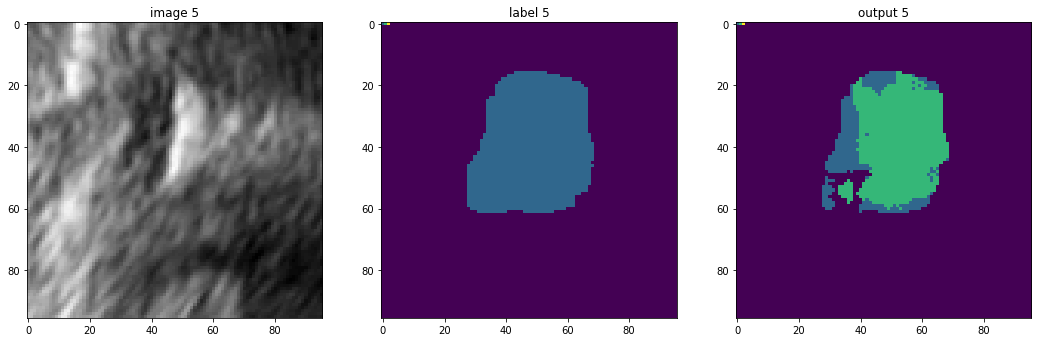

025ns_Image_262499828648_clean_ClassN_83-179.roi.mha


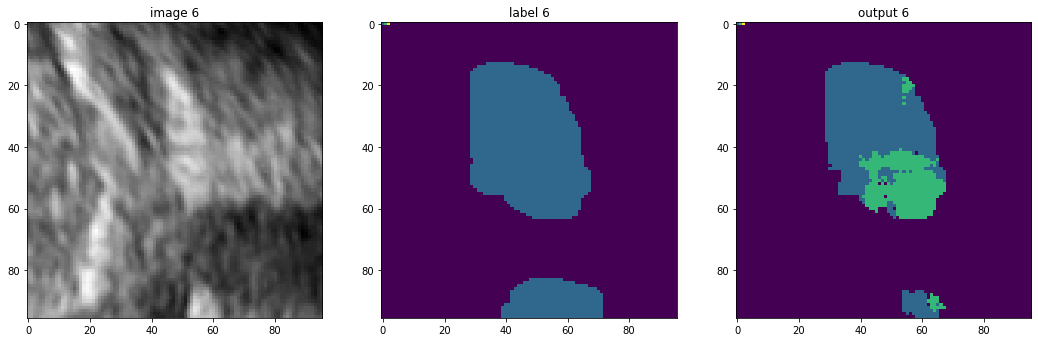

025ns_image_267456908021_clean_ClassN_155-251.roi.mha


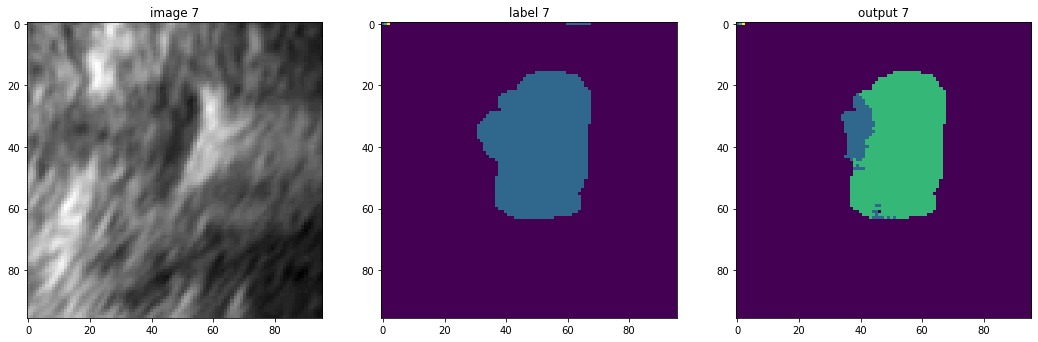

025ns_image_267456908021_clean_ClassN_9-105.roi.mha


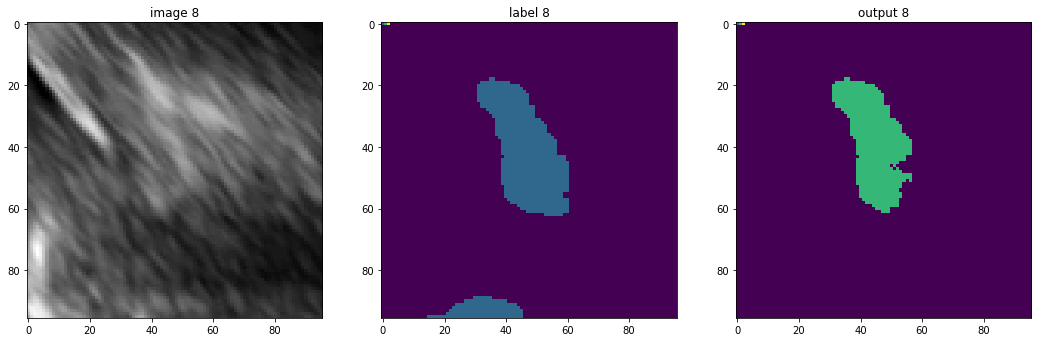

025ns_image_267456908021_clean_ClassN_91-187.roi.mha


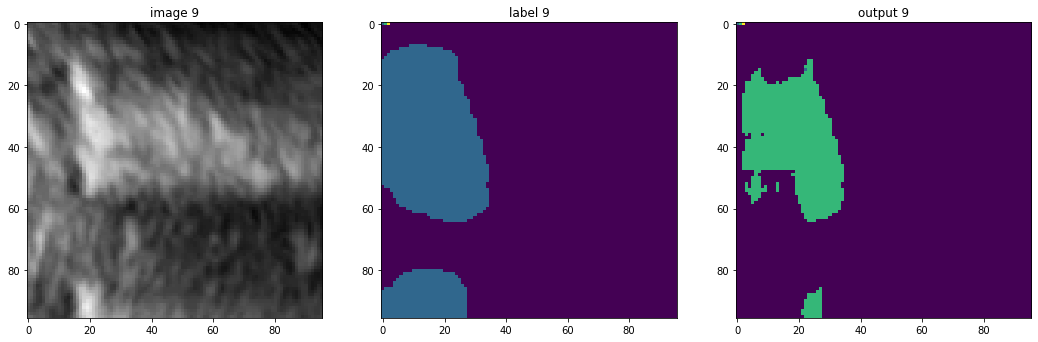

025n Counts per class =  1 4
  Winner = NOT Sliding


026ns_image_1083297968960_clean_ClassN_168-264.roi.mha


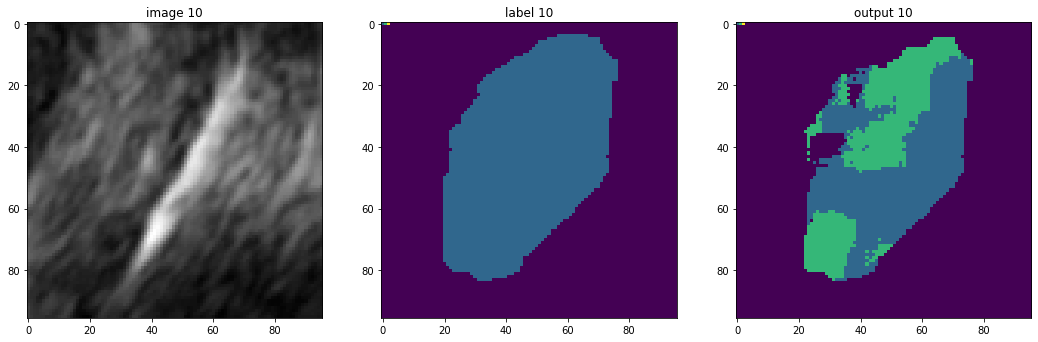

026ns_image_1083297968960_clean_ClassN_77-173.roi.mha


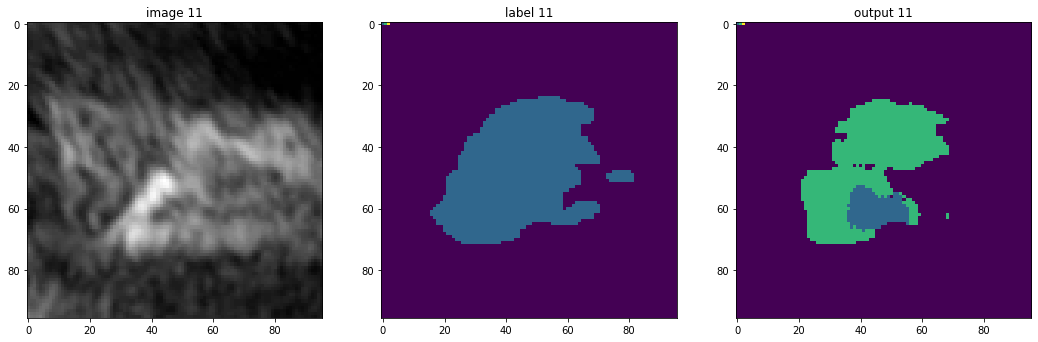

026ns_image_1087766719219_clean_ClassN_174-270.roi.mha


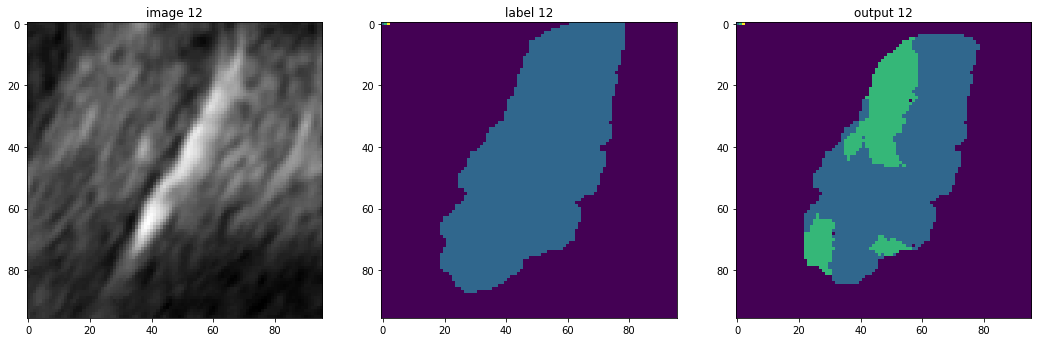

026ns_image_1087766719219_clean_ClassN_80-176.roi.mha


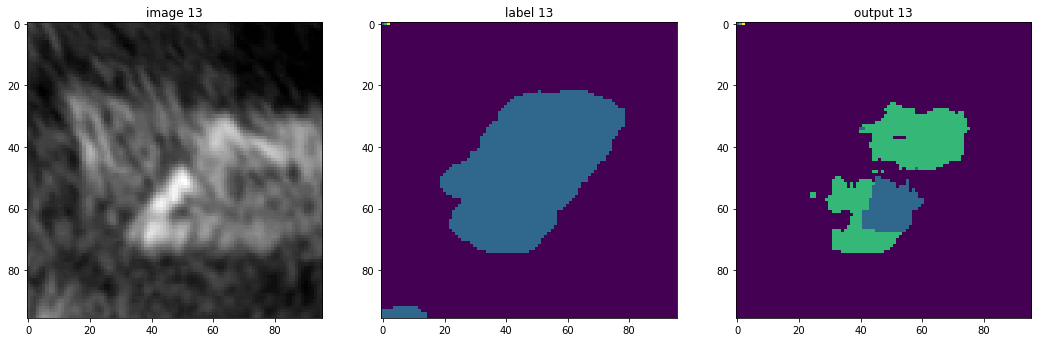

026n Counts per class =  1 3
  Winner = NOT Sliding


VFOLD = 2 of 10


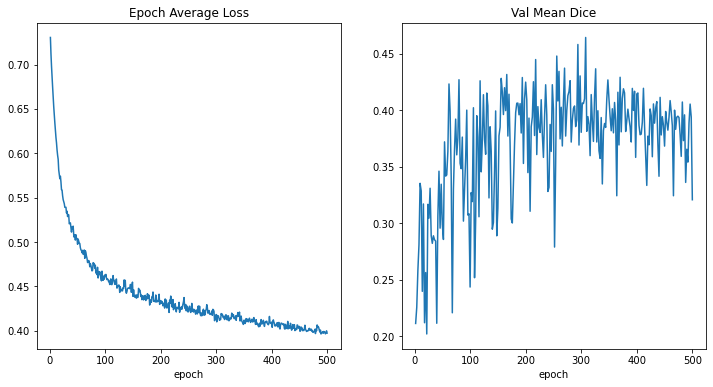

019s_iimage_10705997566592_CLEAN_ClassS_144-240.roi.mha


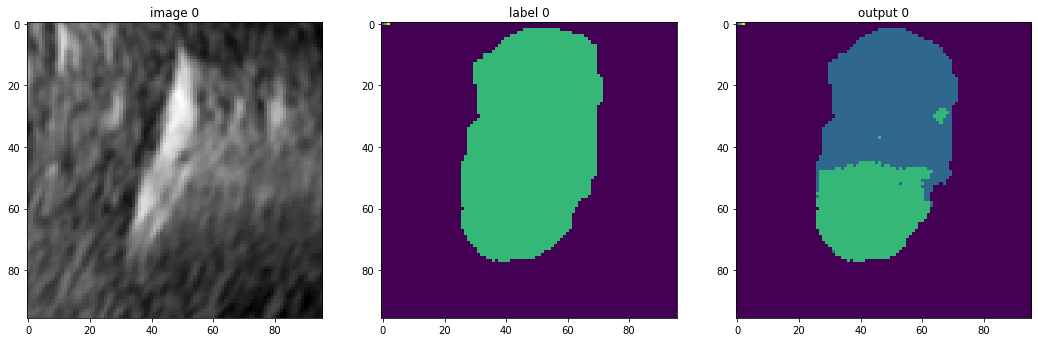

019s_iimage_10705997566592_CLEAN_ClassS_43-139.roi.mha


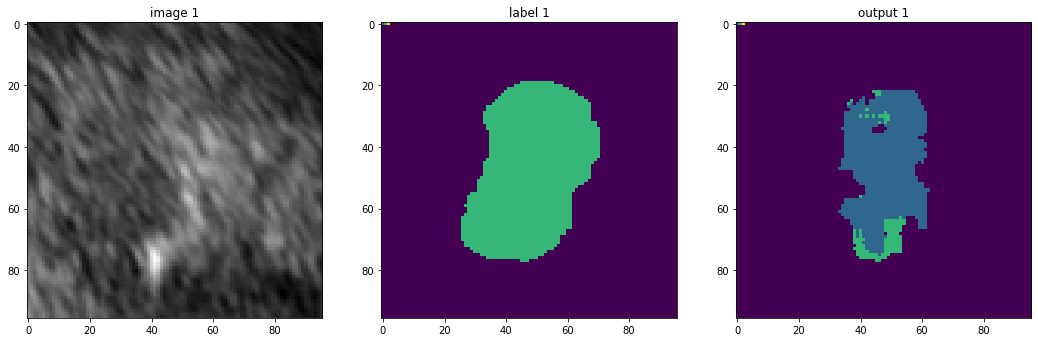

019s_iimage_10891015221417_clean_ClassS_167-263.roi.mha


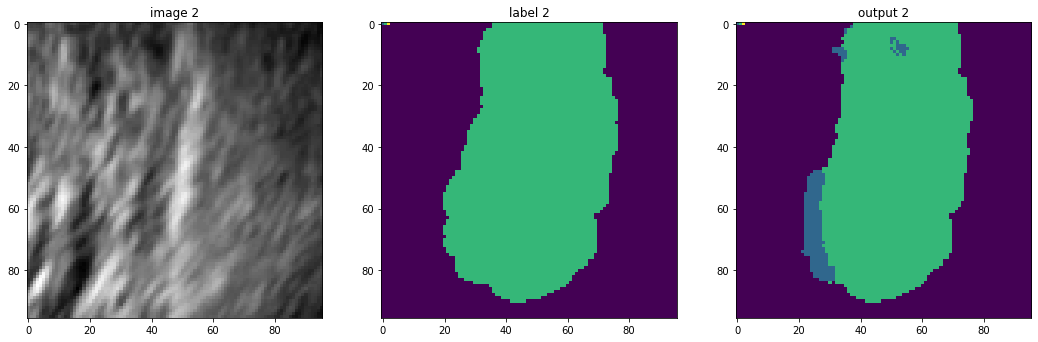

019s Counts per class =  1 2
  Winner = NOT Sliding


027ns_image_4641643404894_CLEAN_ClassN_181-277.roi.mha


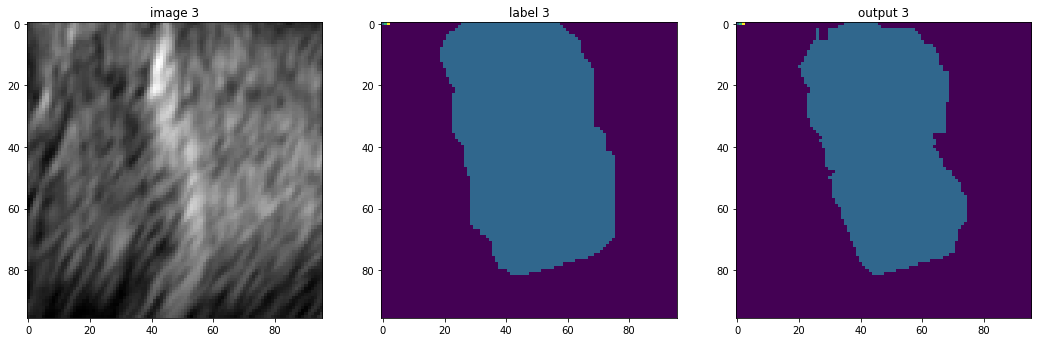

027ns_image_4641643404894_CLEAN_ClassN_37-133.roi.mha


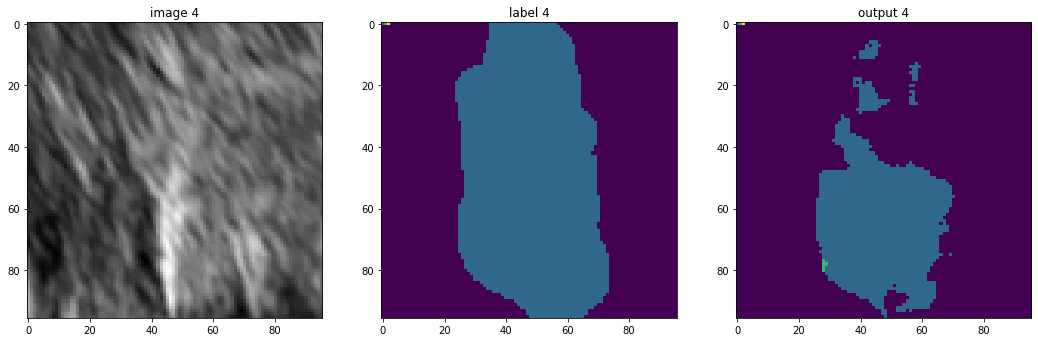

027ns_image_4743880599022_clean_ClassN_163-259.roi.mha


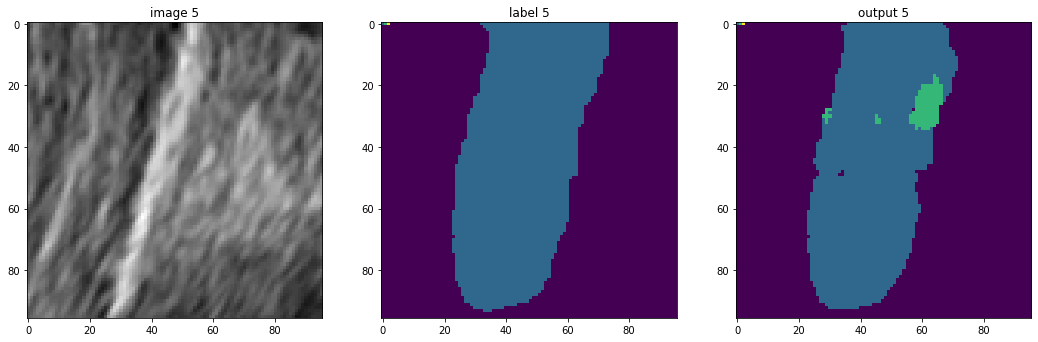

027n Counts per class =  3 0
  Winner = NOT Sliding


030s_iimage_1180496934444_clean_ClassS_155-251.roi.mha


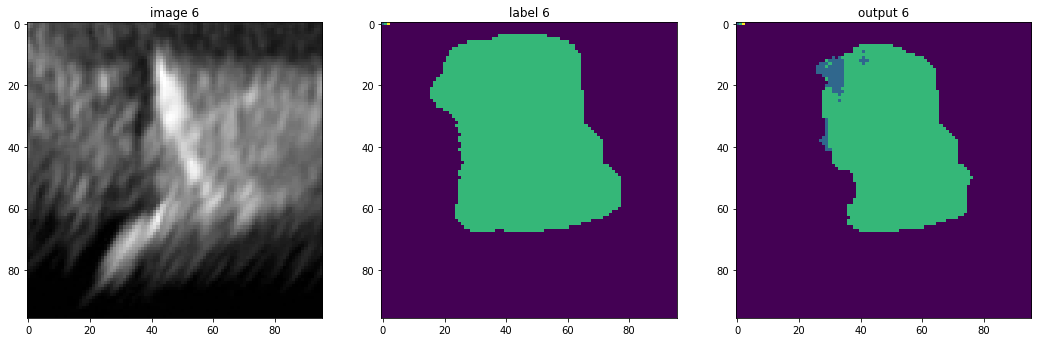

030s_iimage_1180496934444_clean_ClassS_67-163.roi.mha


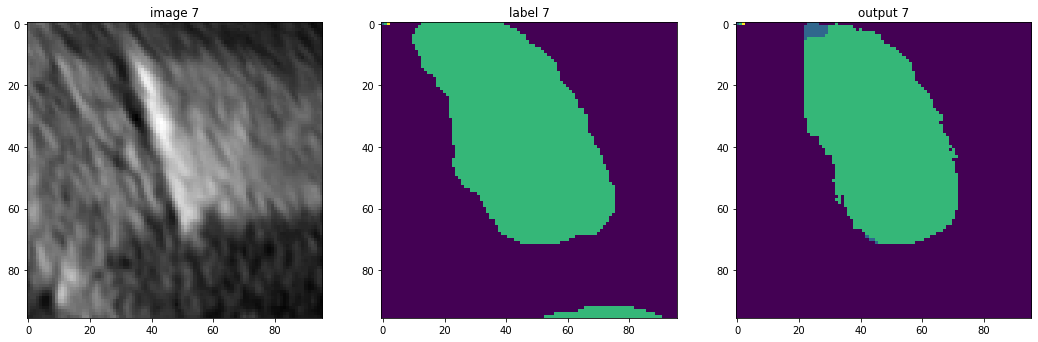

030s_iimage_677741729740_clean_ClassS_148-244.roi.mha


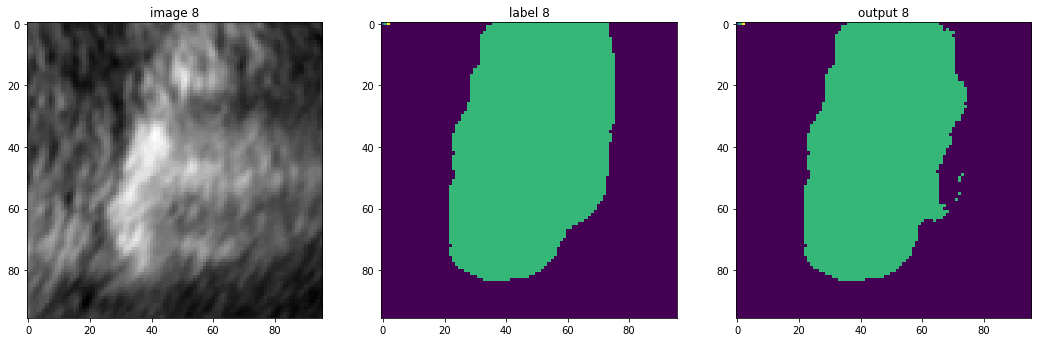

030s Counts per class =  0 3
  Winner = Sliding


VFOLD = 3 of 10


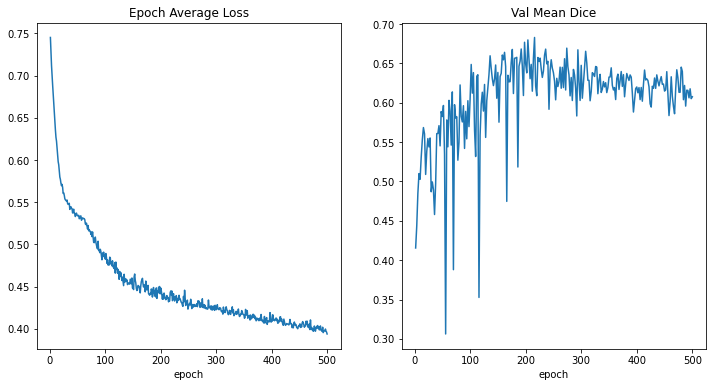

034s_iimage_3368391807672_clean_ClassS_130-226.roi.mha


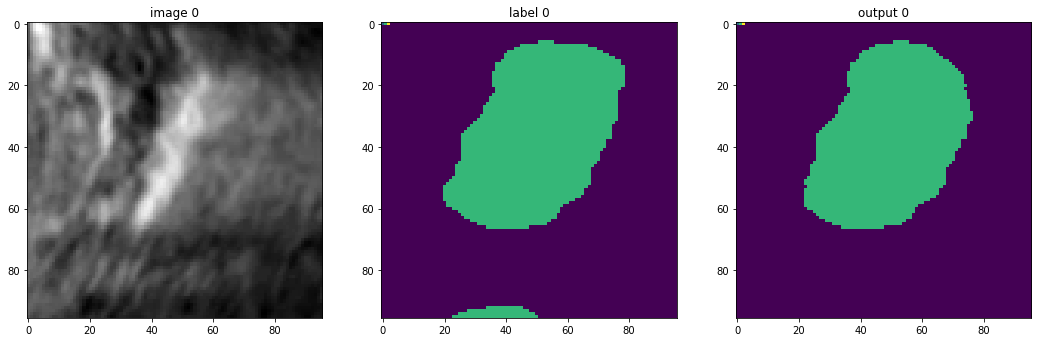

034s_iimage_3368391807672_clean_ClassS_214-310.roi.mha


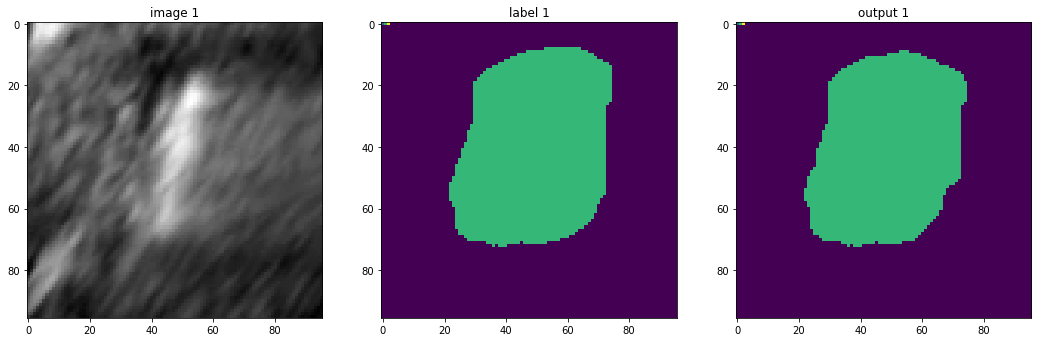

034s_iimage_3368391807672_clean_ClassS_48-144.roi.mha


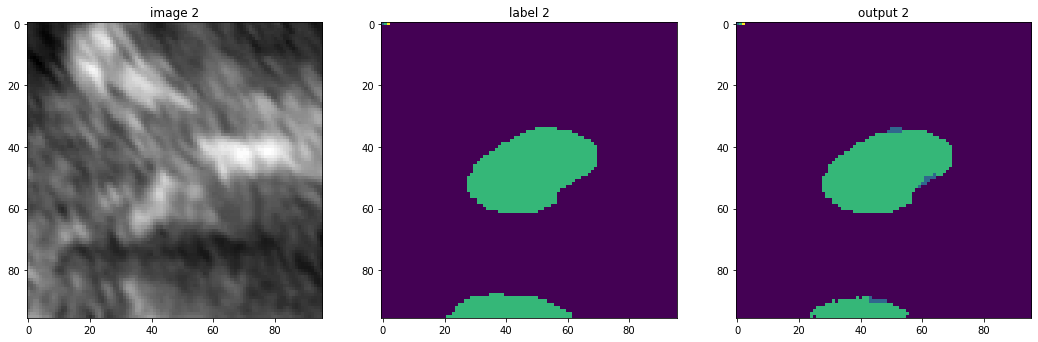

034s_iimage_3401832241774_clean_ClassS_159-255.roi.mha


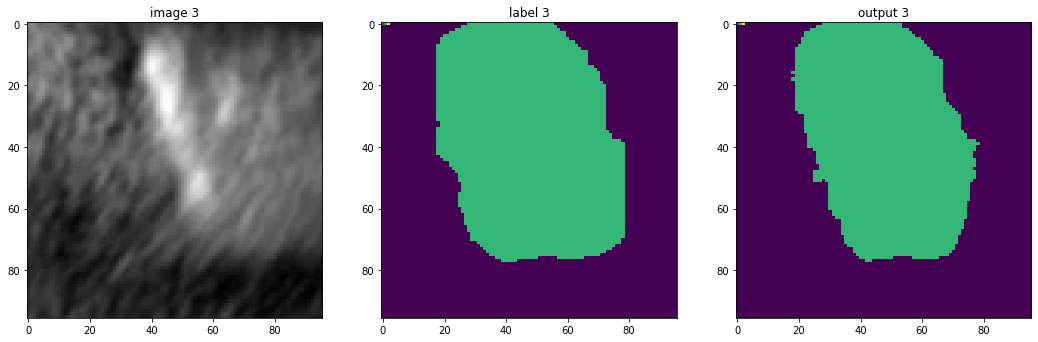

034s_iimage_3401832241774_clean_ClassS_61-157.roi.mha


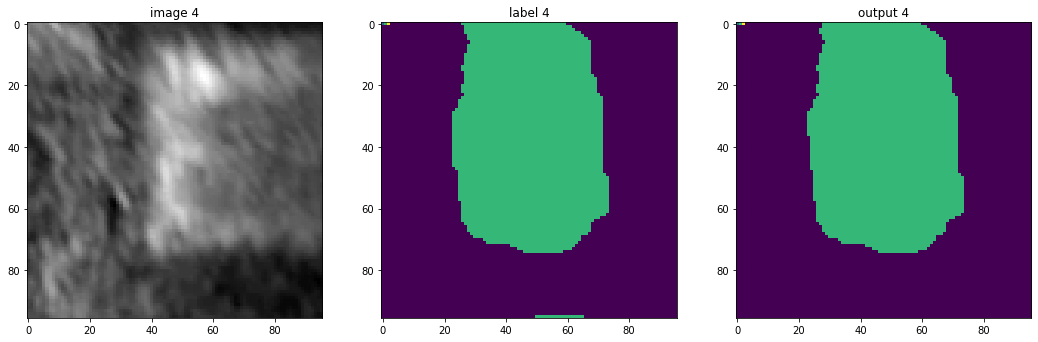

034s Counts per class =  0 5
  Winner = Sliding


035ns_image_1394469579519_clean_ClassN_153-249.roi.mha


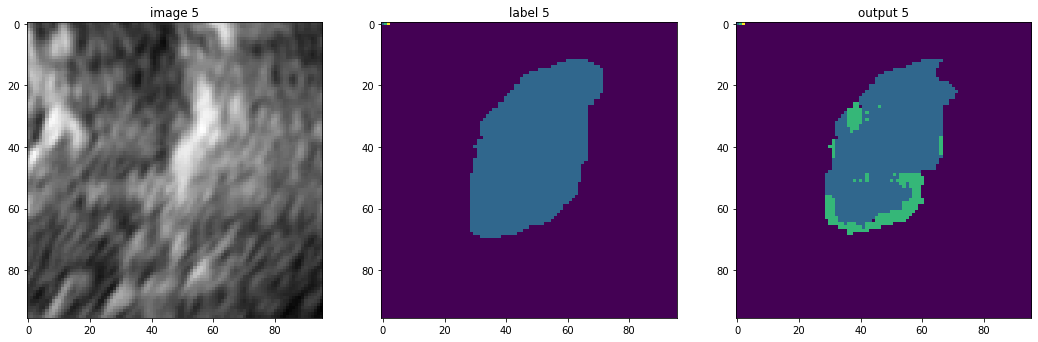

035ns_image_1394469579519_clean_ClassN_27-123.roi.mha


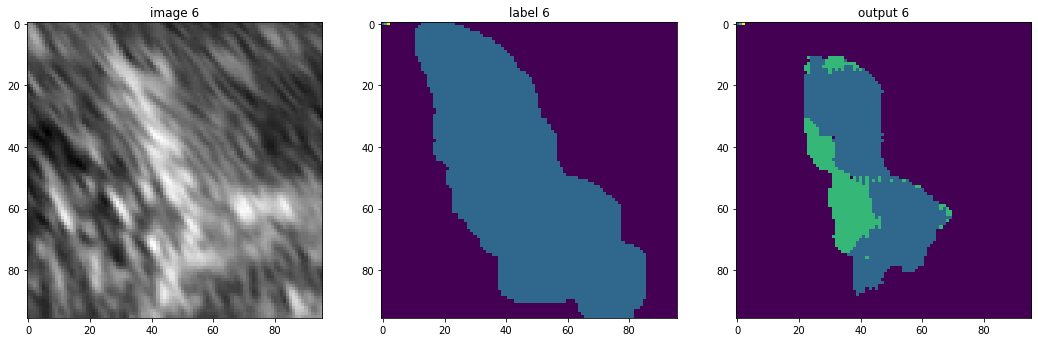

035ns_image_1404802450036_clean_ClassN_165-261.roi.mha


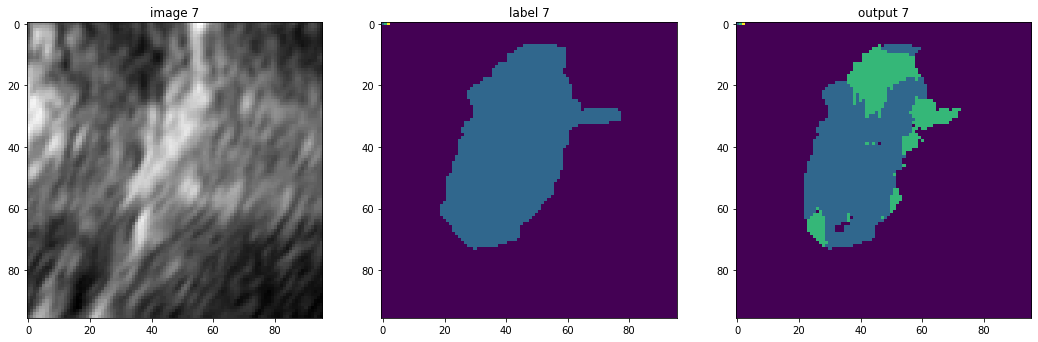

035n Counts per class =  3 0
  Winner = NOT Sliding


048ns_image_1543571117118_clean_ClassN_213-309.roi.mha


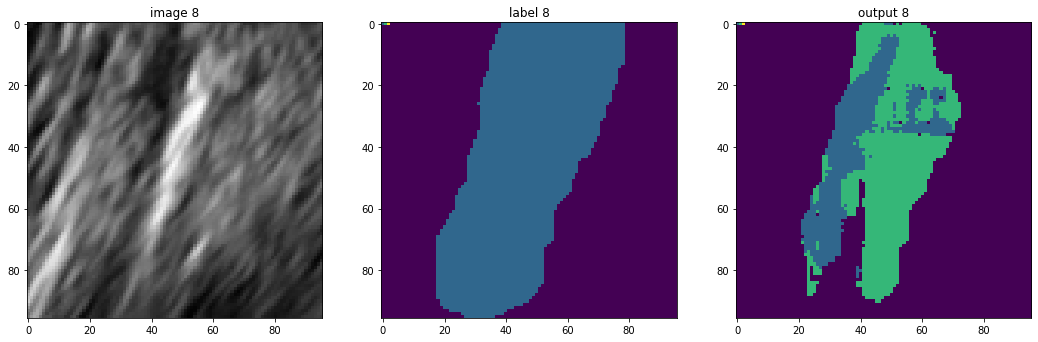

048ns_image_1749559540112_clean_ClassN_223-319.roi.mha


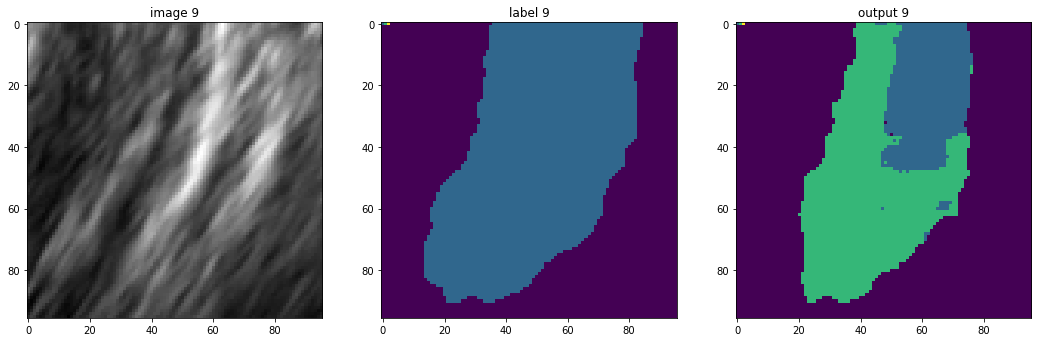

048n Counts per class =  0 2
  Winner = Sliding


VFOLD = 4 of 10


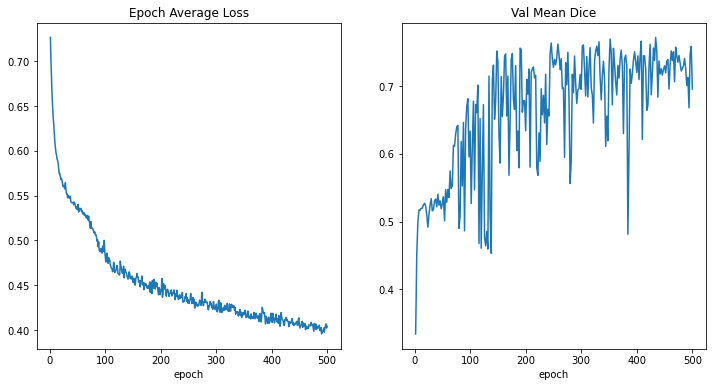

037s_iimage_588413346180_CLEAN_ClassS_202-298.roi.mha


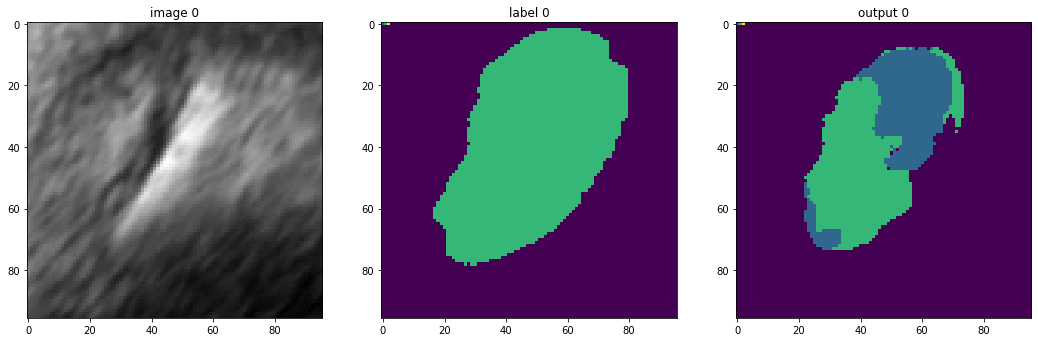

037s_iimage_588413346180_CLEAN_ClassS_98-194.roi.mha


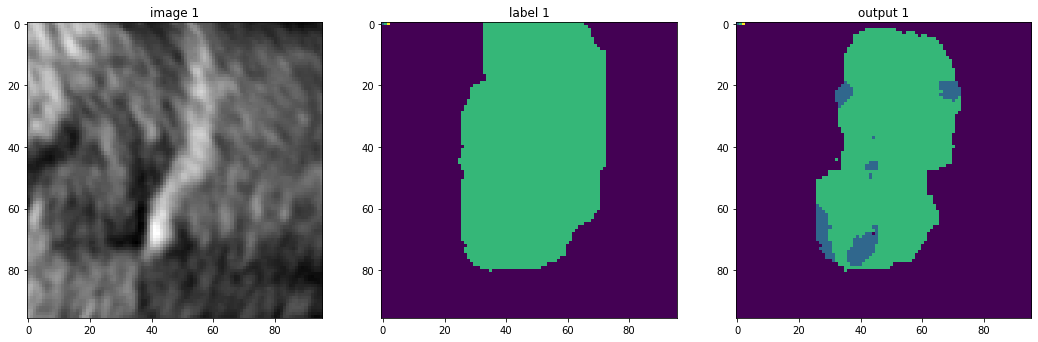

037s Counts per class =  0 2
  Winner = Sliding


043s_iimage_10391571128899_CLEAN_ClassS_116-212.roi.mha


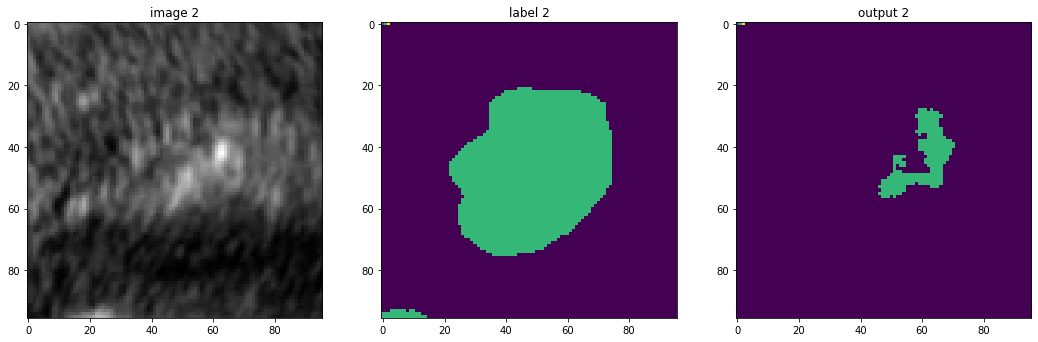

043s_iimage_10391571128899_CLEAN_ClassS_210-306.roi.mha


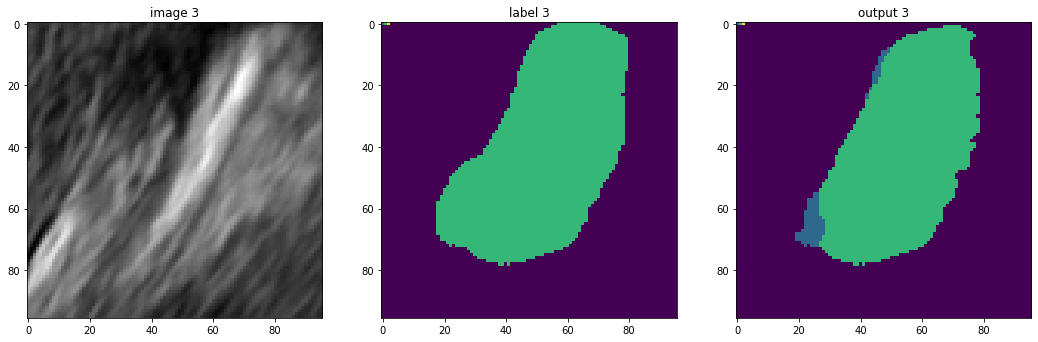

043s_iimage_10395655826502_CLEAN_ClassS_110-206.roi.mha


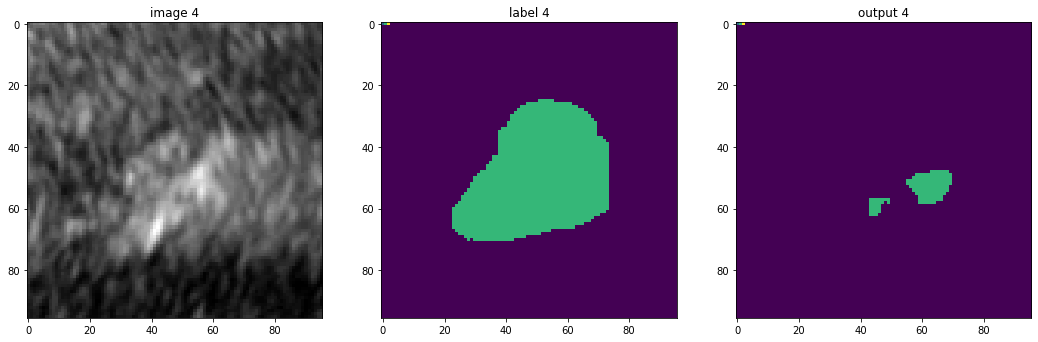

043s_iimage_10395655826502_CLEAN_ClassS_216-312.roi.mha


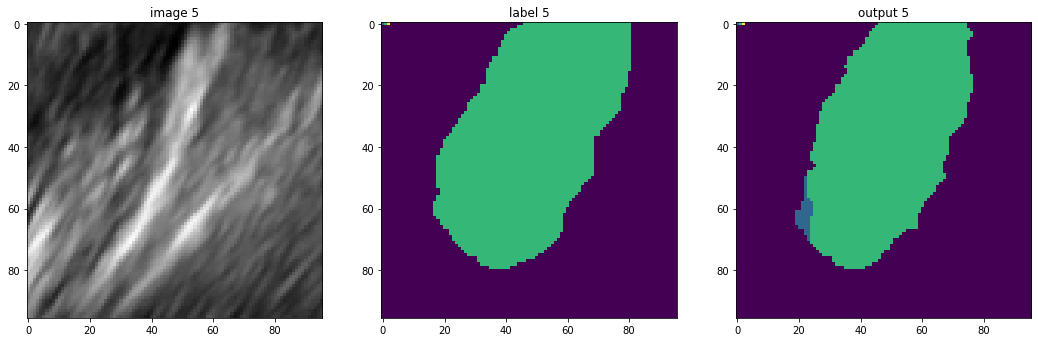

043s Counts per class =  0 4
  Winner = Sliding


055ns_image_27180764486244_CLEAN_ClassN_115-211.roi.mha


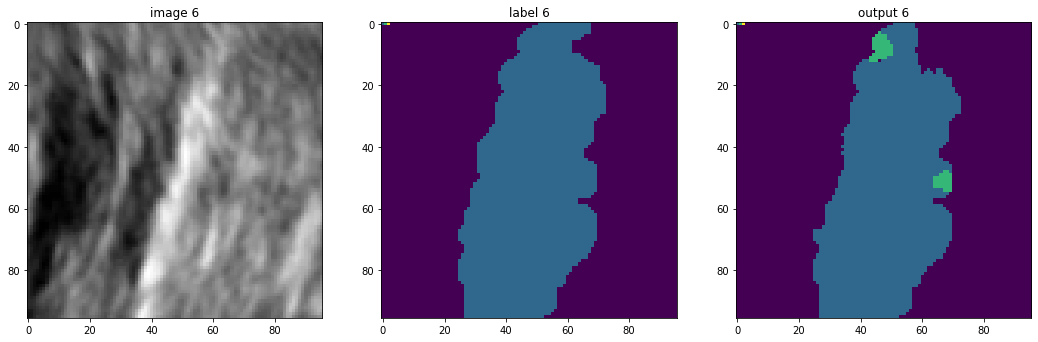

055ns_image_27185428518326_CLEAN_ClassN_117-213.roi.mha


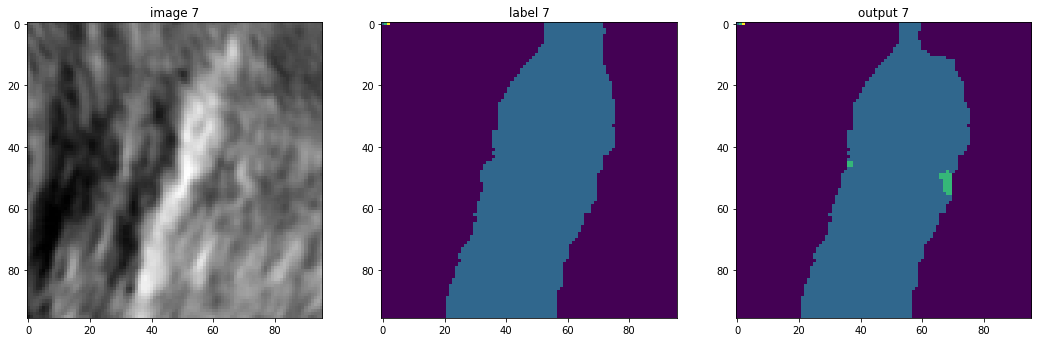

055n Counts per class =  2 0
  Winner = NOT Sliding


VFOLD = 5 of 10


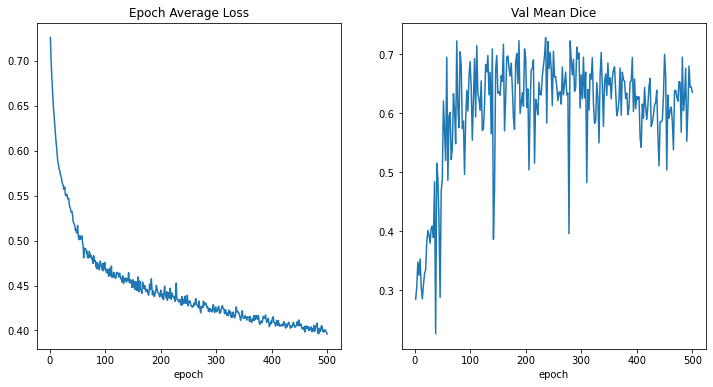

065s_iimage_1896534330004_clean_ClassS_159-255.roi.mha


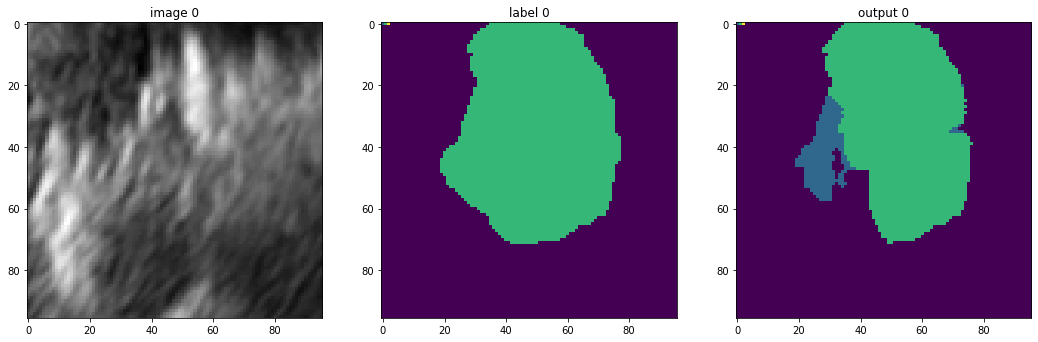

065s_iimage_1896534330004_clean_ClassS_35-131.roi.mha


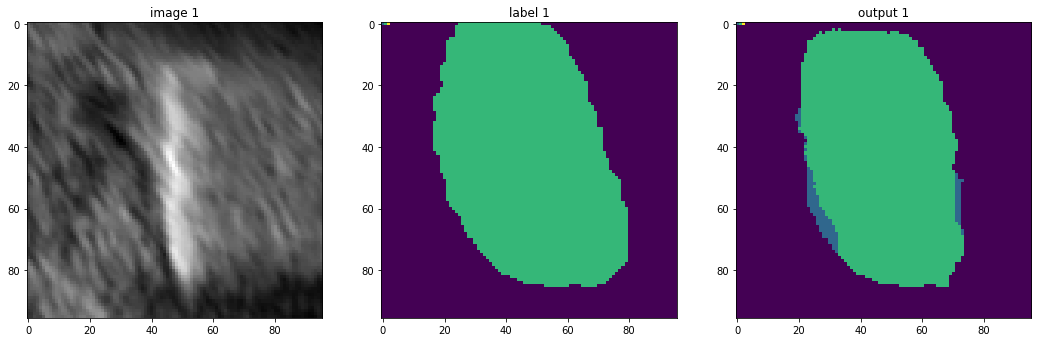

065s_iimage_1901852337971_clean_ClassS_164-260.roi.mha


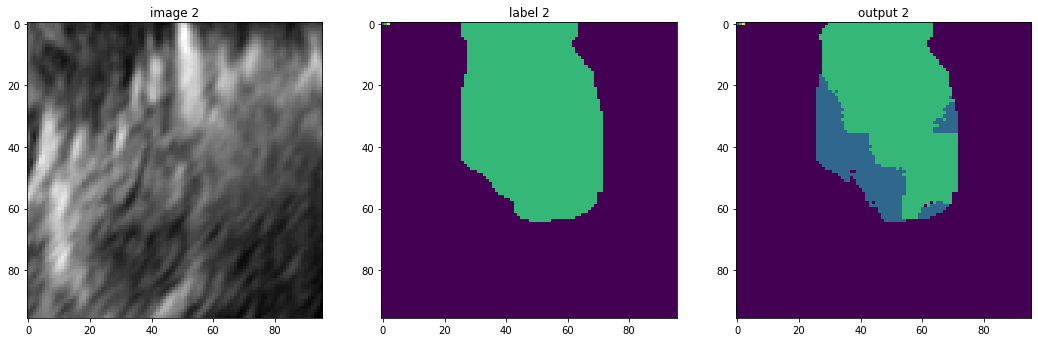

065s_iimage_1901852337971_clean_ClassS_43-139.roi.mha


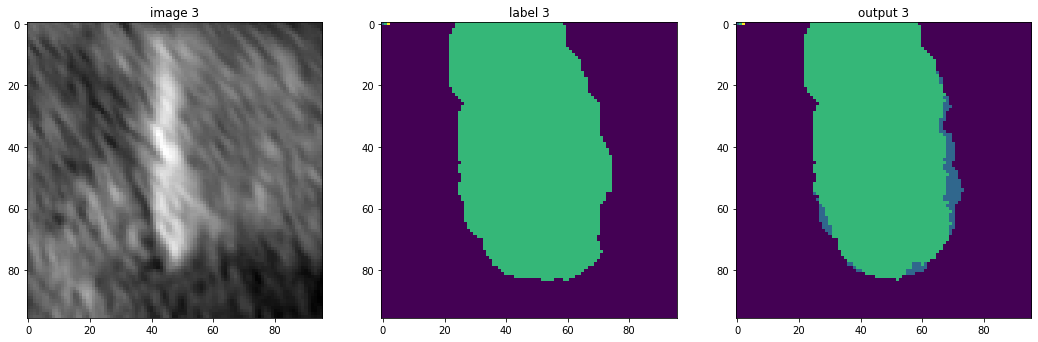

065s Counts per class =  0 4
  Winner = Sliding


117ns_image_417221672548_CLEAN_ClassN_73-169.roi.mha


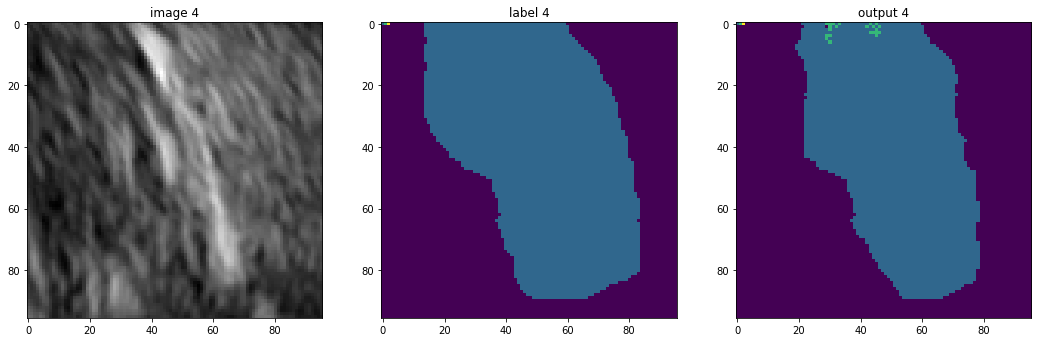

117ns_image_426794579576_CLEAN_ClassN_172-268.roi.mha


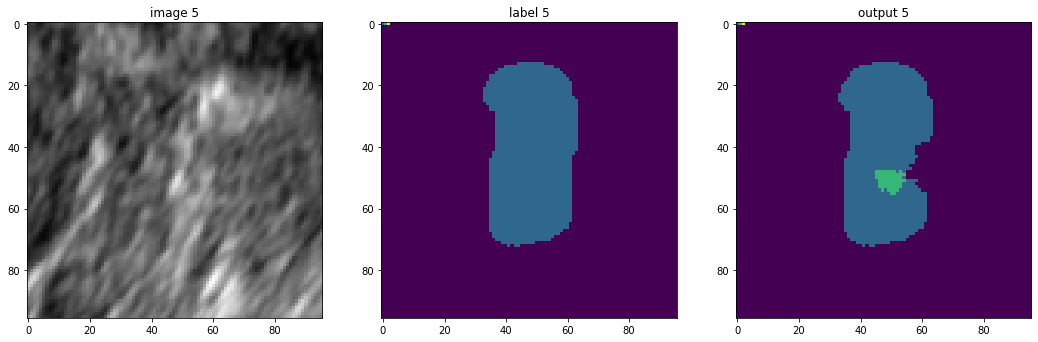

117ns_image_426794579576_CLEAN_ClassN_52-148.roi.mha


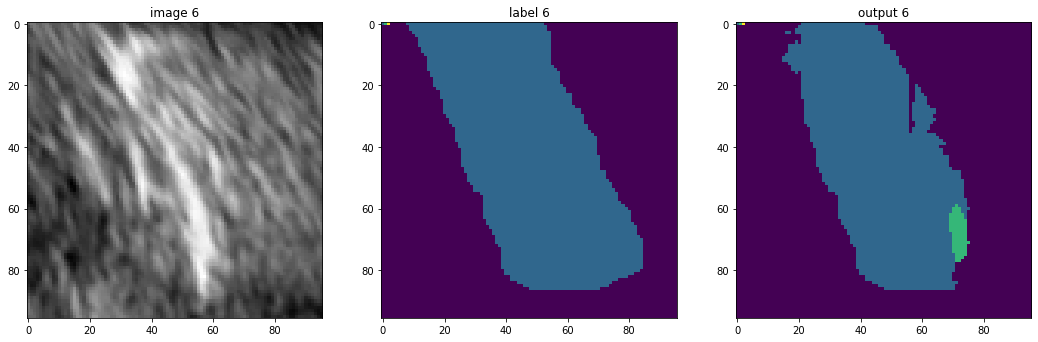

117n Counts per class =  3 0
  Winner = NOT Sliding


135ns_image_2418161753608_clean_ClassN_103-199.roi.mha


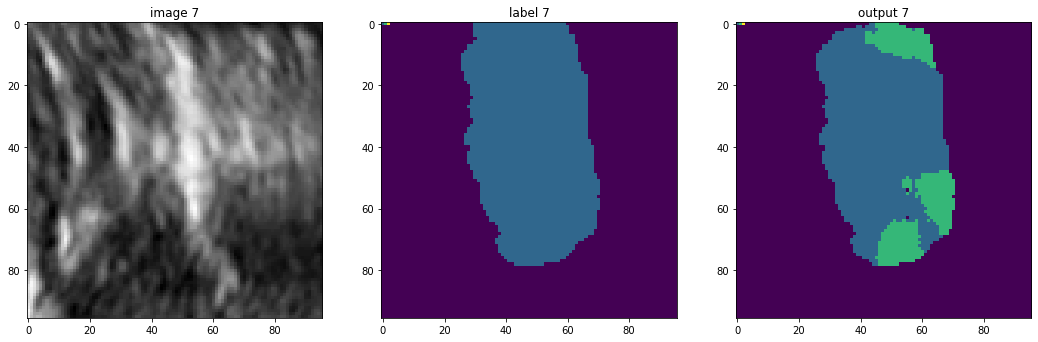

135ns_image_2454526567135_CLEAN_ClassN_123-219.roi.mha


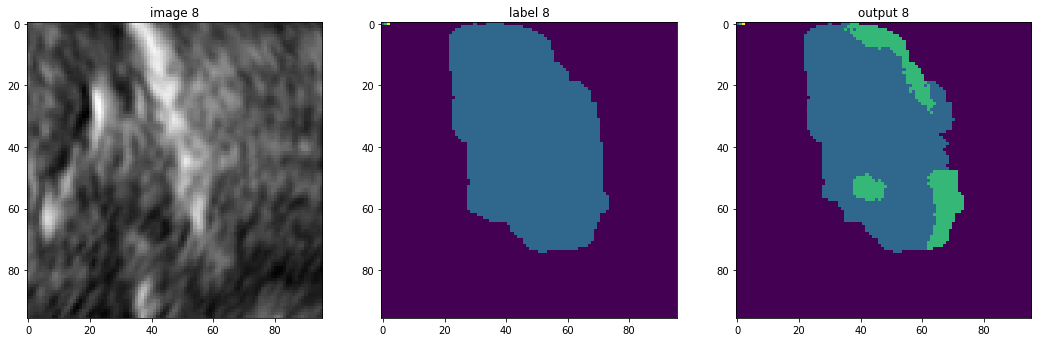

135n Counts per class =  2 0
  Winner = NOT Sliding


VFOLD = 6 of 10


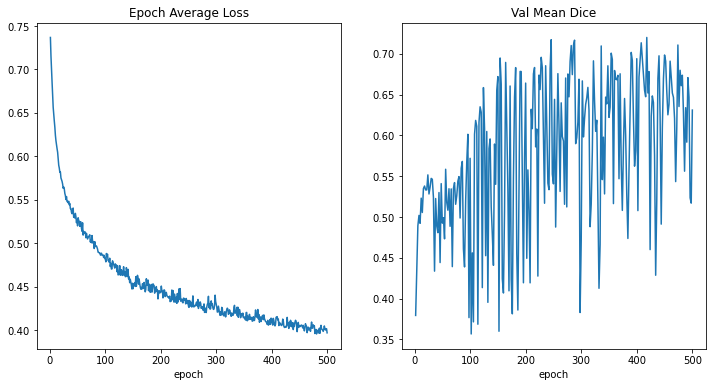

081s_iimage_2959672151786_clean_ClassS_152-248.roi.mha


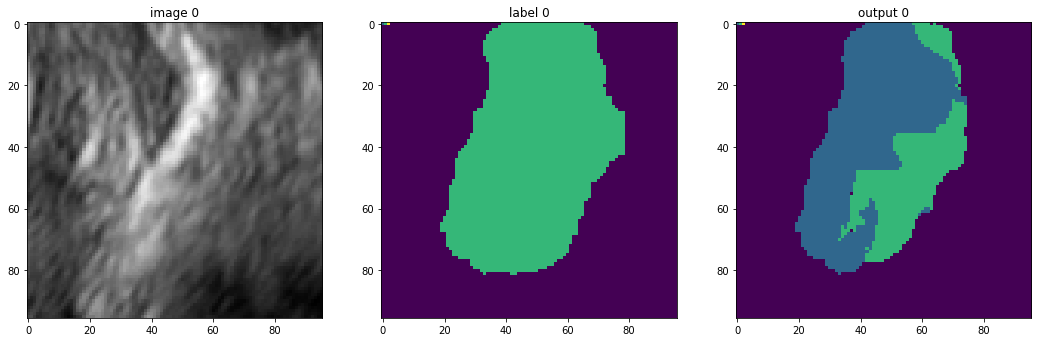

081s_iimage_2959672151786_clean_ClassS_43-139.roi.mha


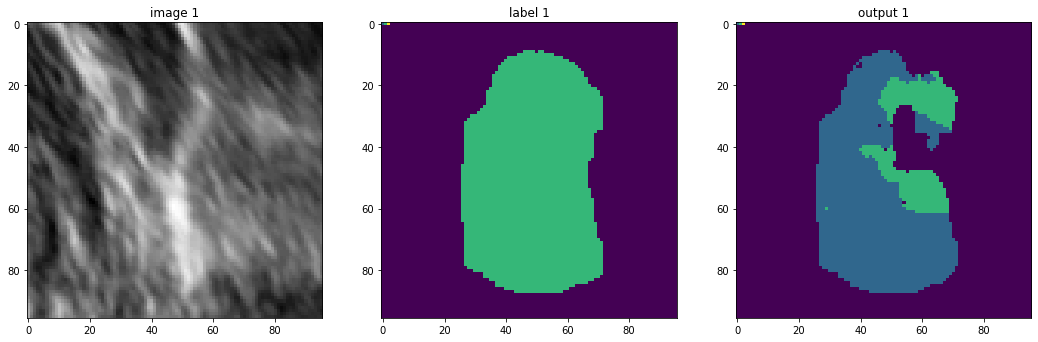

081s_iimage_3320344386805_clean_ClassS_111-207.roi.mha


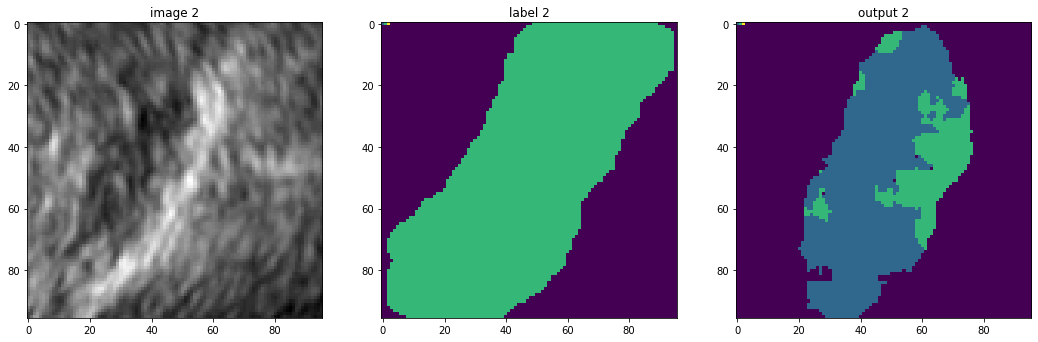

081s Counts per class =  3 0
  Winner = NOT Sliding


193ns_image_634125159704_CLEAN_ClassN_181-277.roi.mha


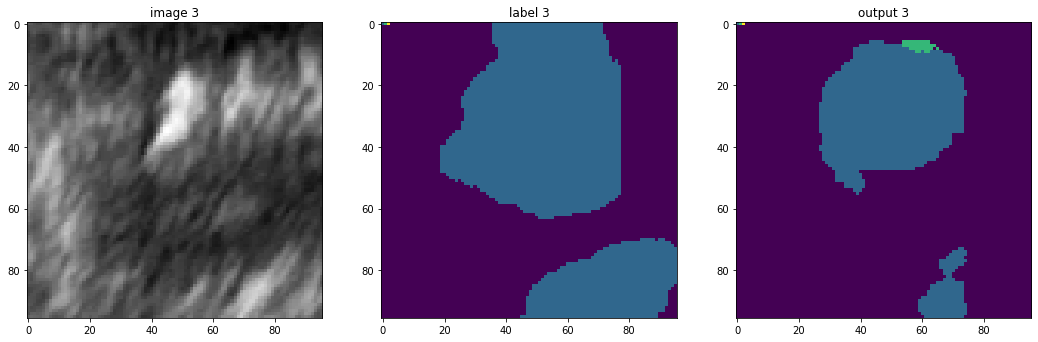

193ns_image_634125159704_CLEAN_ClassN_224-320.roi.mha


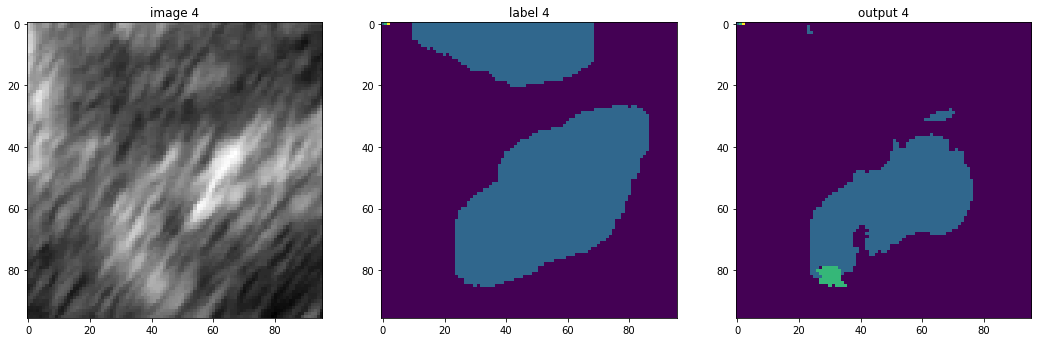

193ns_image_634125159704_CLEAN_ClassN_52-148.roi.mha


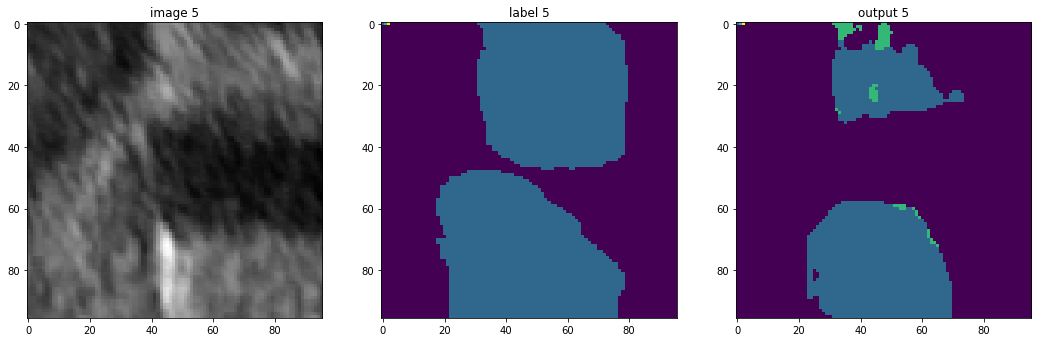

193ns_image_642169070951_clean_ClassN_0-96.roi.mha


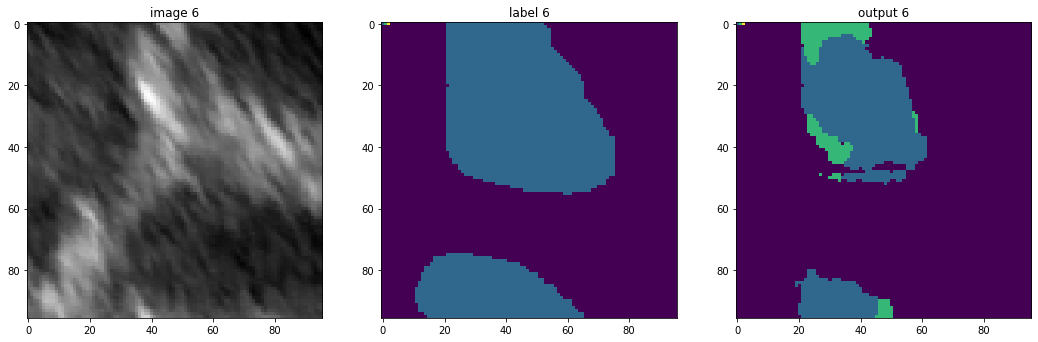

193ns_image_642169070951_clean_ClassN_147-243.roi.mha


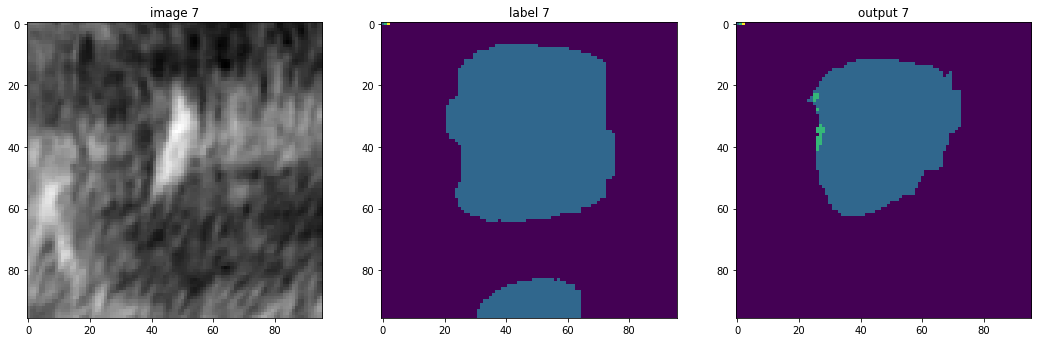

193ns_image_642169070951_clean_ClassN_216-312.roi.mha


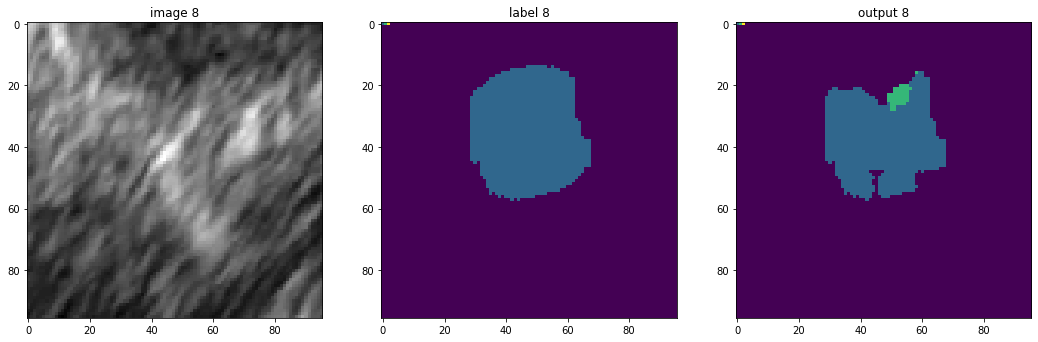

193ns_image_642169070951_clean_ClassN_71-167.roi.mha


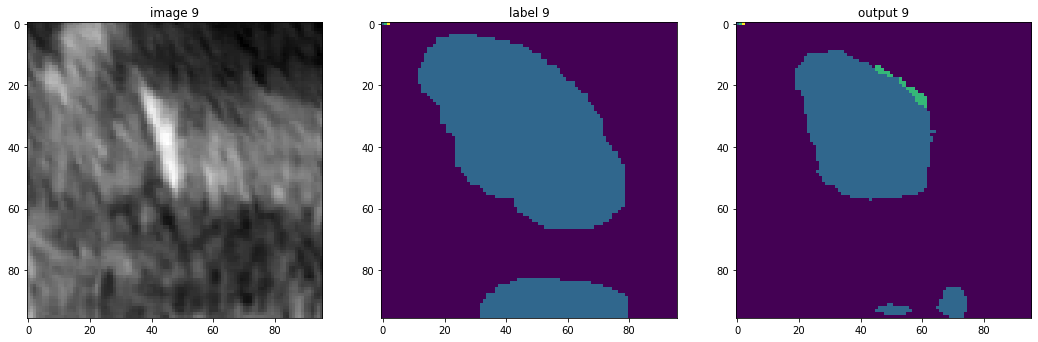

193n Counts per class =  7 0
  Winner = NOT Sliding


206s_iimage_1499268364374_clean_ClassS_112-208.roi.mha


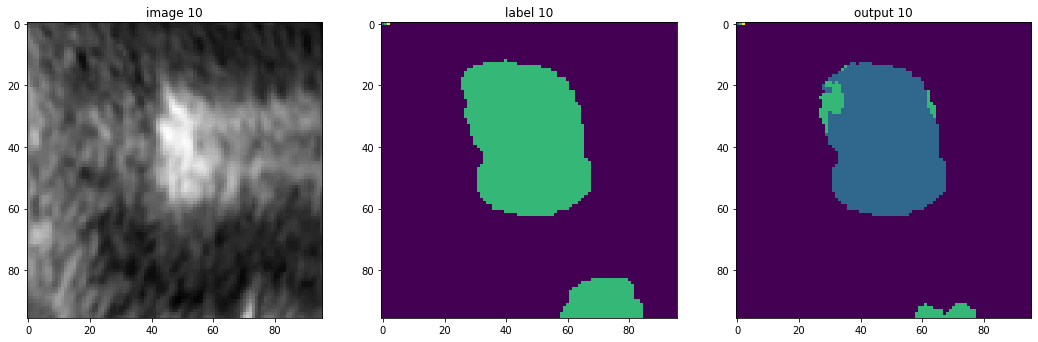

206s_iimage_1499268364374_clean_ClassS_184-280.roi.mha


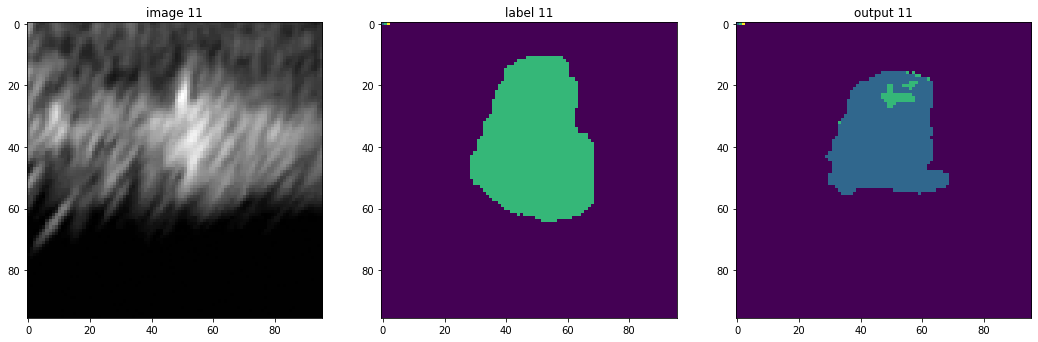

206s_iimage_1499268364374_clean_ClassS_39-135.roi.mha


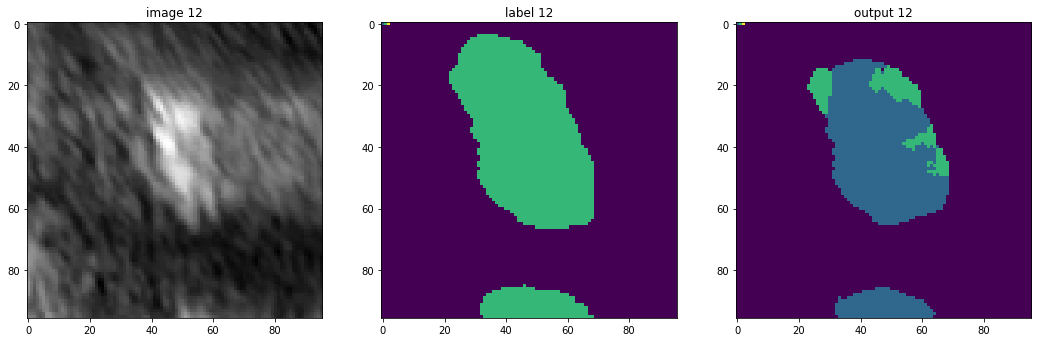

206s_iimage_1511338287338_clean_ClassS_0-96.roi.mha


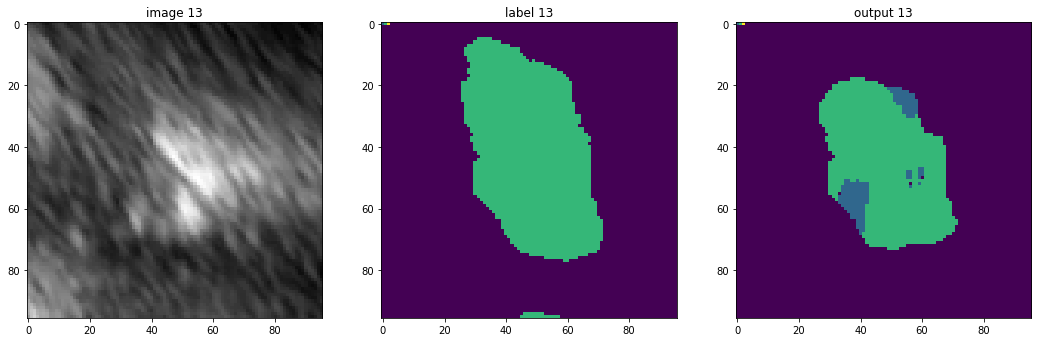

206s_iimage_1511338287338_clean_ClassS_161-257.roi.mha


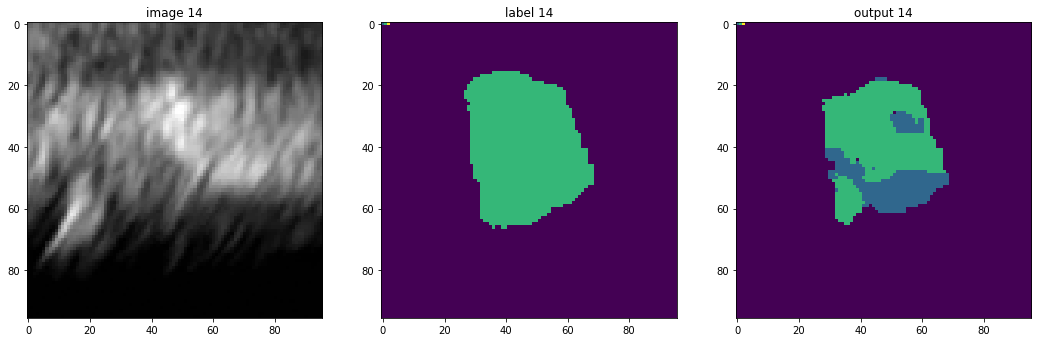

206s_iimage_1511338287338_clean_ClassS_89-185.roi.mha


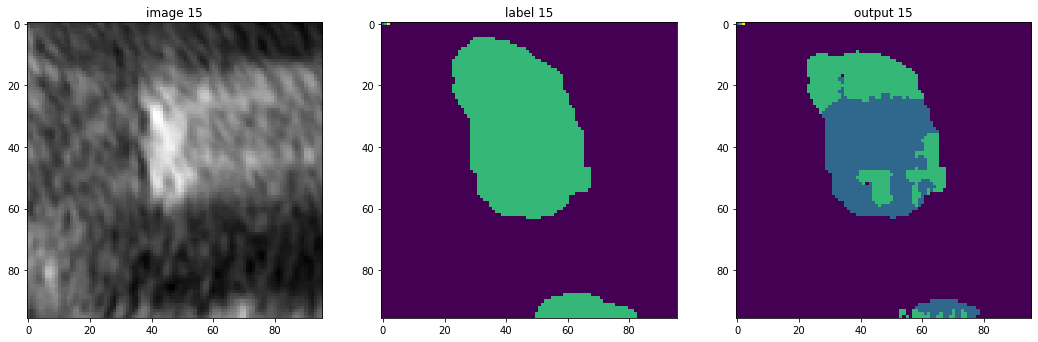

206s Counts per class =  3 3
  Winner = NOT Sliding


VFOLD = 7 of 10


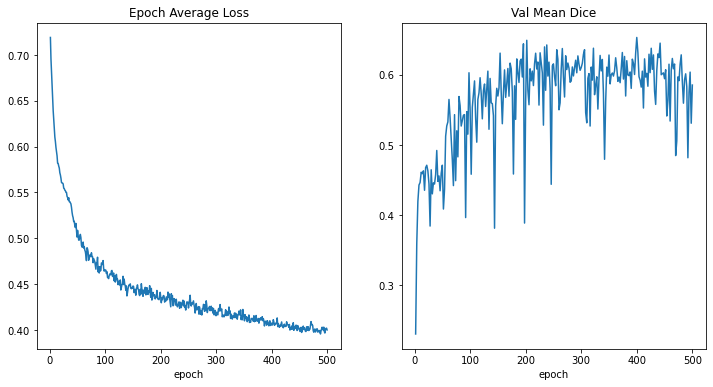

208s_iimage_104543812690743_CLEAN_ClassS_132-228.roi.mha


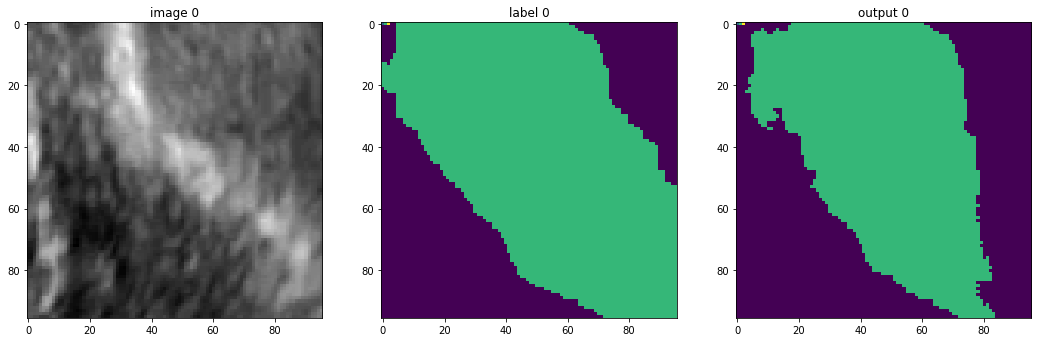

208s_iimage_104548309385533_CLEAN_ClassS_136-232.roi.mha


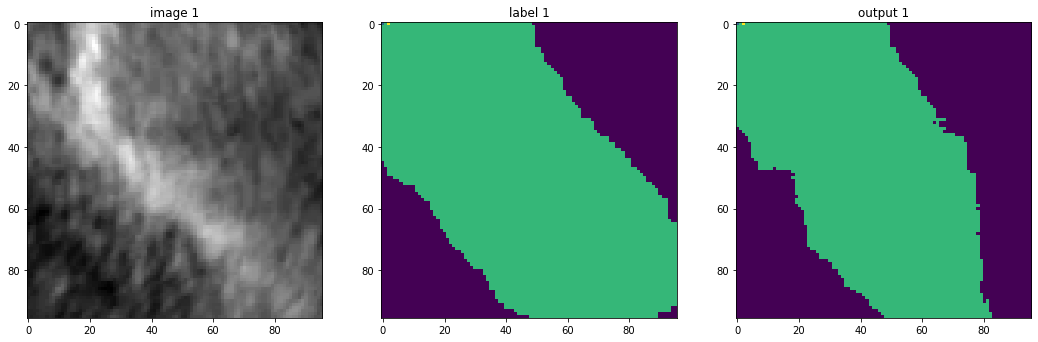

208s_iimage_104932526155699_CLEAN_ClassS_114-210.roi.mha


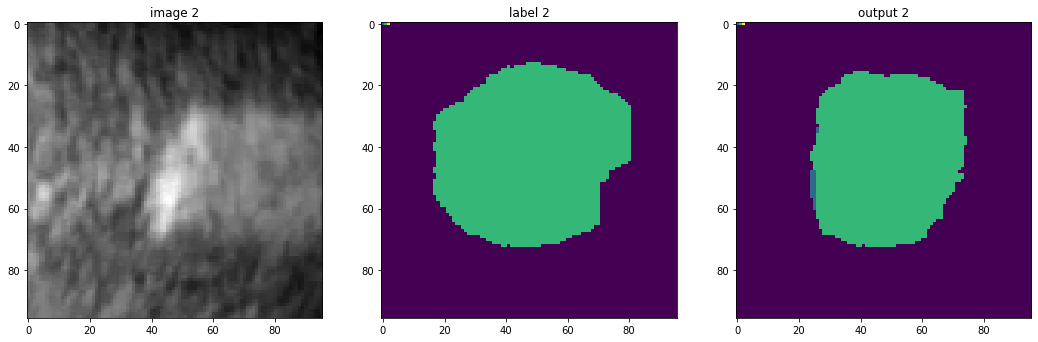

208s Counts per class =  0 3
  Winner = Sliding


210ns_image_603665940081_clean_ClassN_128-224.roi.mha


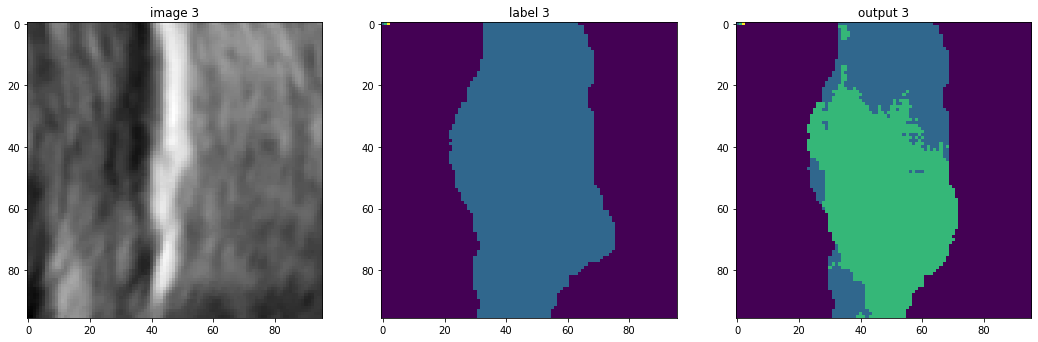

210ns_image_614587120545_clean_ClassN_110-206.roi.mha


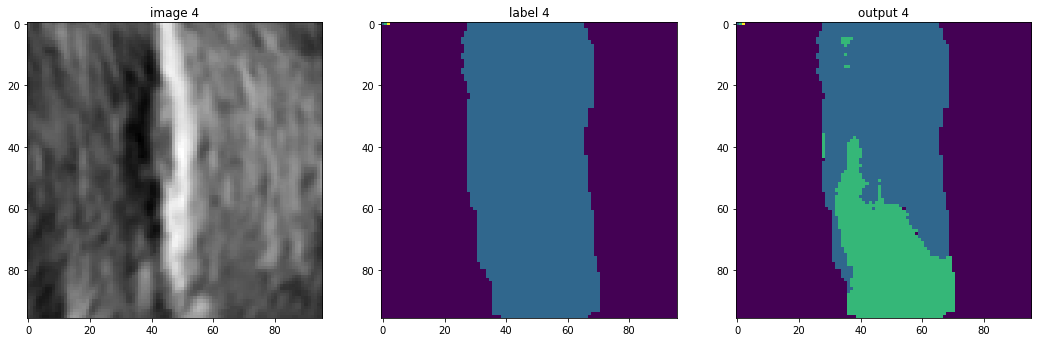

210n Counts per class =  0 2
  Winner = Sliding


215ns_image_573611404207_CLEAN_ClassN_143-239.roi.mha


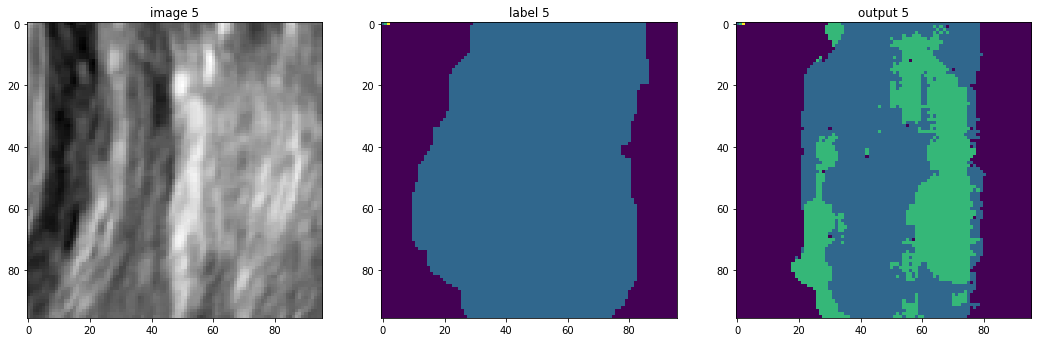

215ns_image_610066411380_CLEAN_ClassN_123-219.roi.mha


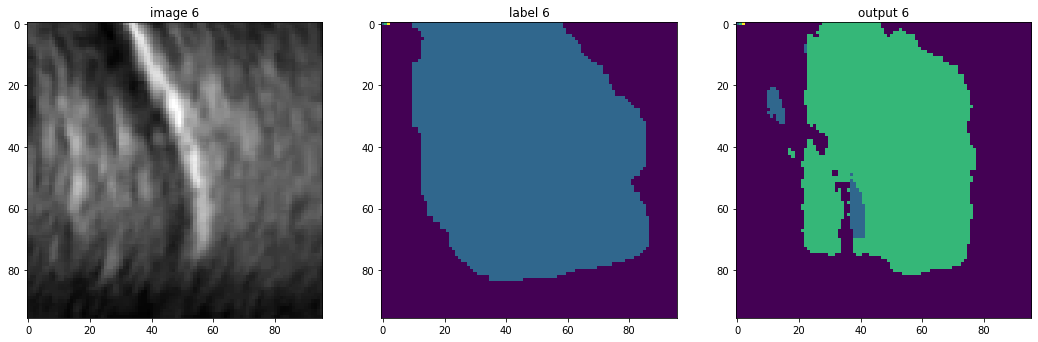

215n Counts per class =  0 2
  Winner = Sliding


VFOLD = 8 of 10


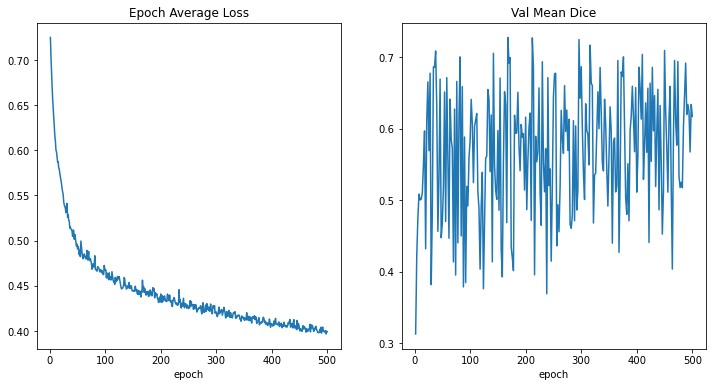

211s_iimage_3925135436261_clean_ClassS_101-197.roi.mha


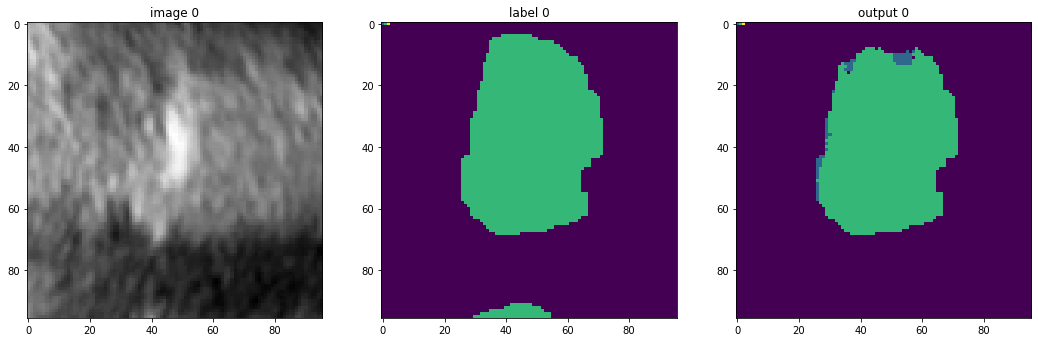

211s_iimage_3925135436261_clean_ClassS_192-288.roi.mha


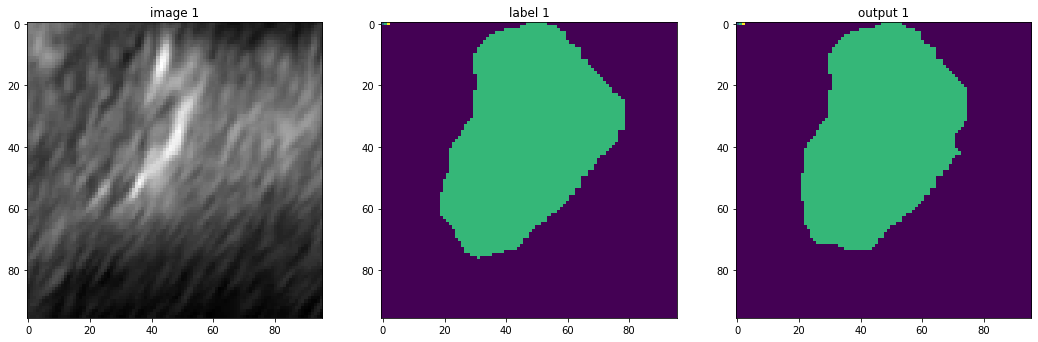

211s_iimage_3925135436261_clean_ClassS_8-104.roi.mha


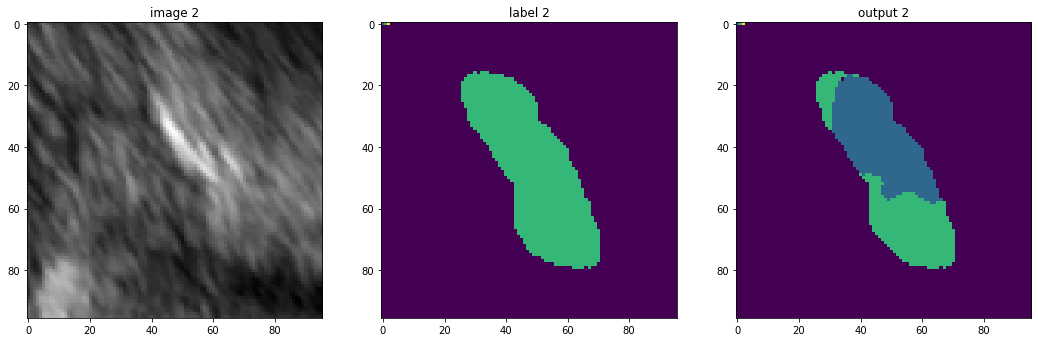

211s_iimage_3929217595322_clean_ClassS_191-287.roi.mha


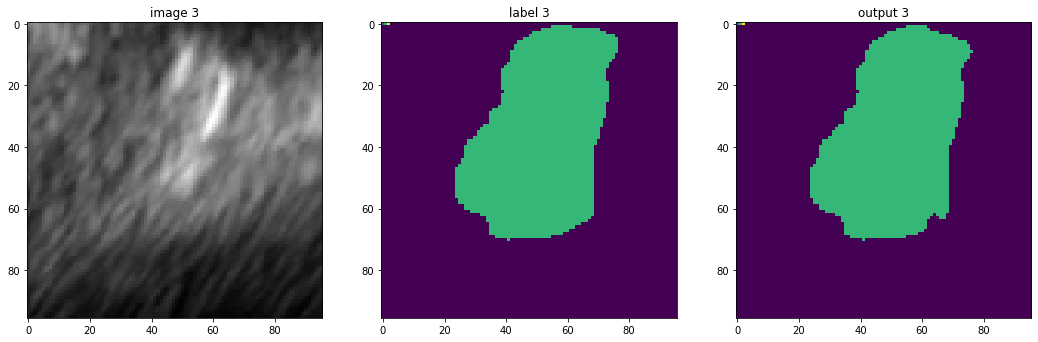

211s_iimage_3929217595322_clean_ClassS_99-195.roi.mha


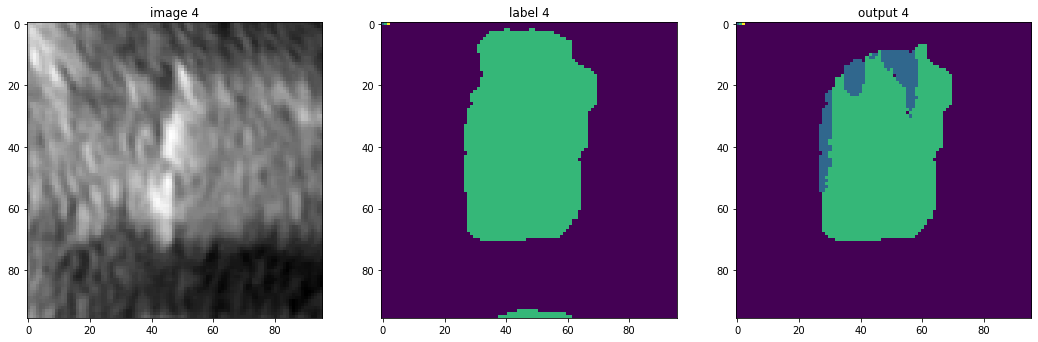

211s Counts per class =  0 5
  Winner = Sliding


212s_iimage_128683942015128_CLEAN_ClassS_178-274.roi.mha


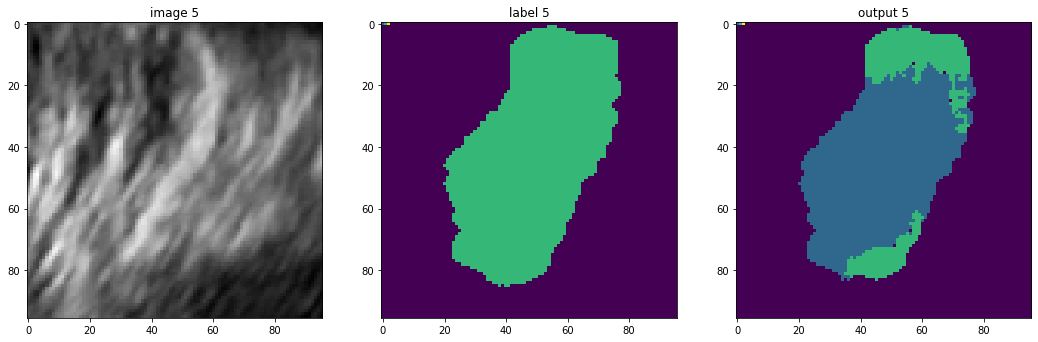

212s_iimage_128683942015128_CLEAN_ClassS_48-144.roi.mha


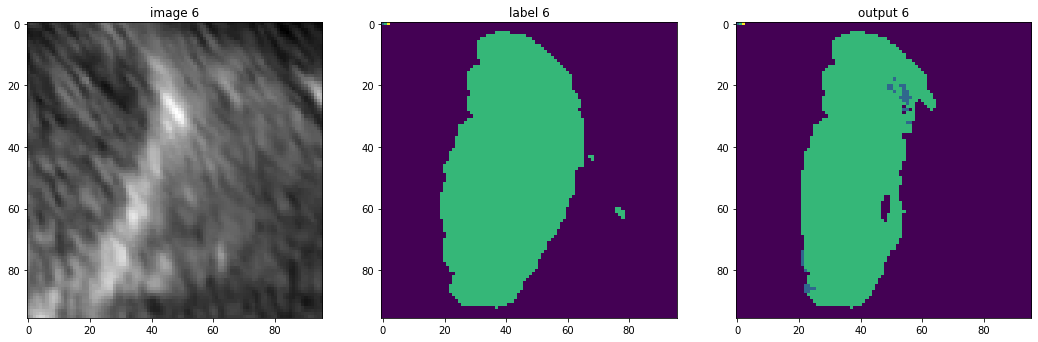

212s_iimage_128688523296793_CLEAN_ClassS_178-274.roi.mha


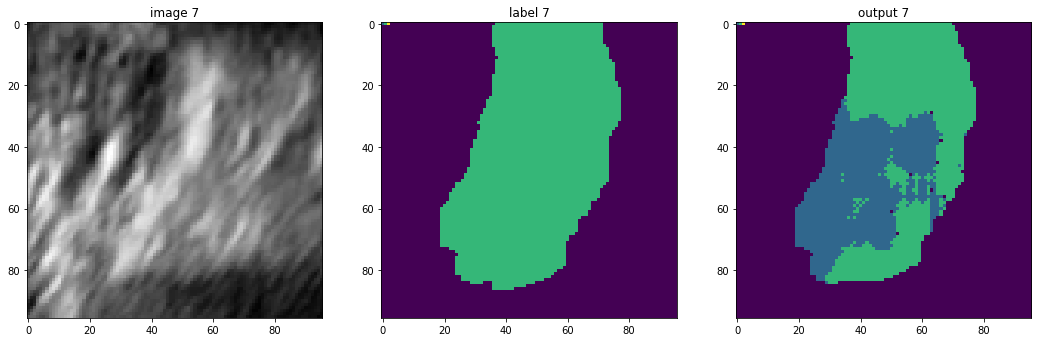

212s_iimage_128688523296793_CLEAN_ClassS_43-139.roi.mha


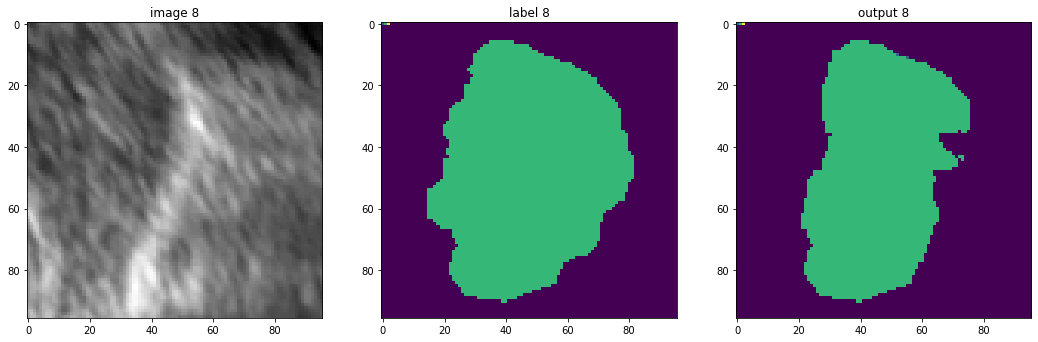

212s_iimage_128692595484031_CLEAN_ClassS_177-273.roi.mha


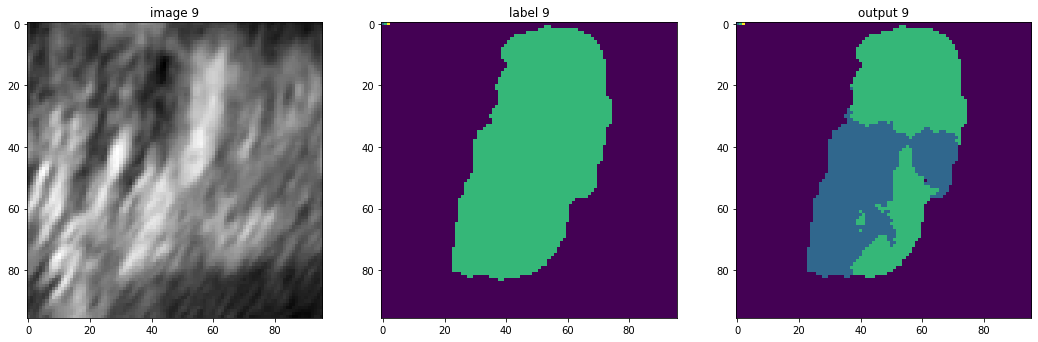

212s_iimage_128692595484031_CLEAN_ClassS_44-140.roi.mha


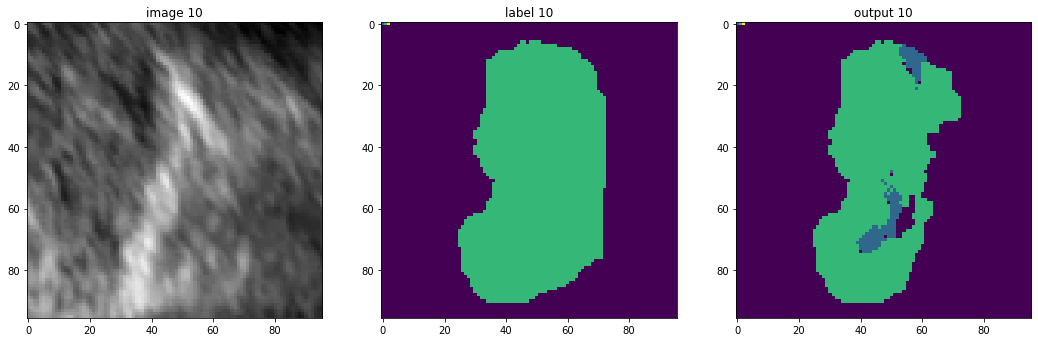

212s Counts per class =  1 5
  Winner = NOT Sliding


218ns_image_6056976176281_CLEAN_ClassN_115-211.roi.mha


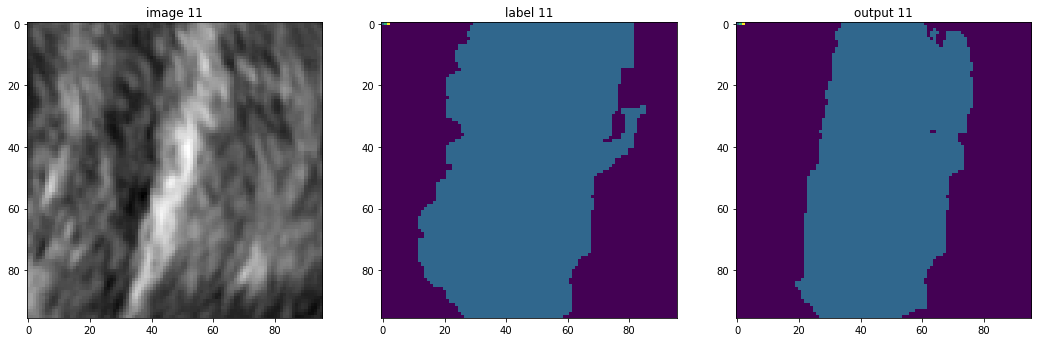

218ns_image_6370410622099_CLEAN_ClassN_0-96.roi.mha


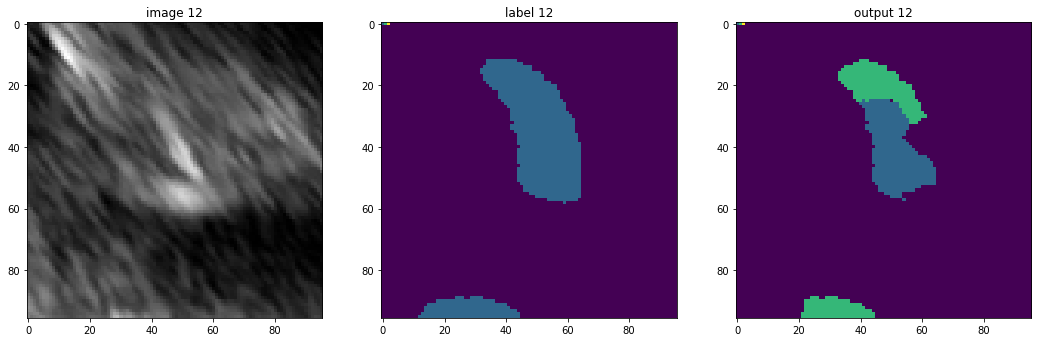

218ns_image_6370410622099_CLEAN_ClassN_157-253.roi.mha


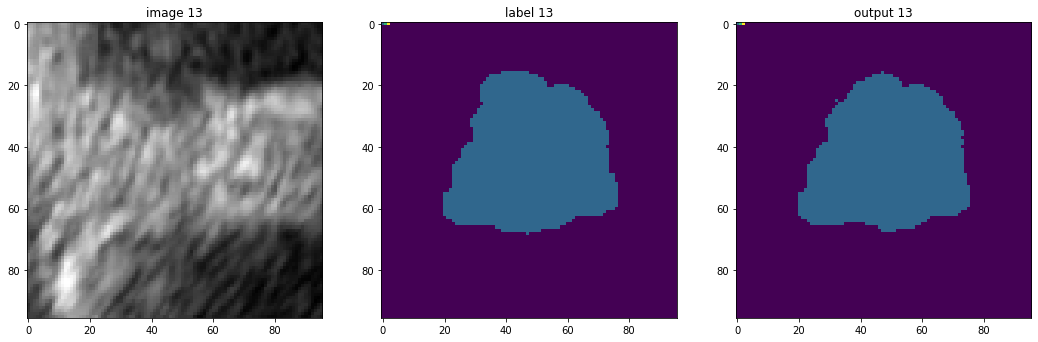

218ns_image_6370410622099_CLEAN_ClassN_78-174.roi.mha


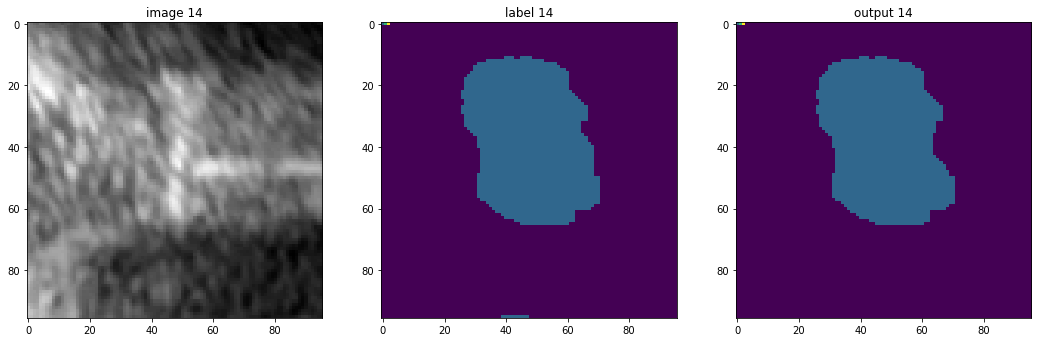

218n Counts per class =  3 1
  Winner = NOT Sliding


VFOLD = 9 of 10


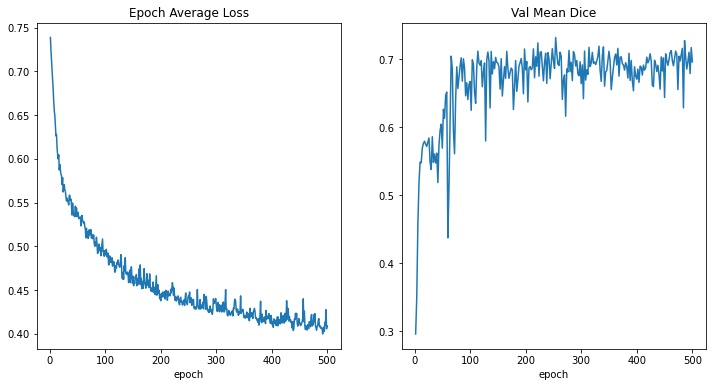

219ns_image_1884162273498_clean_ClassN_166-262.roi.mha


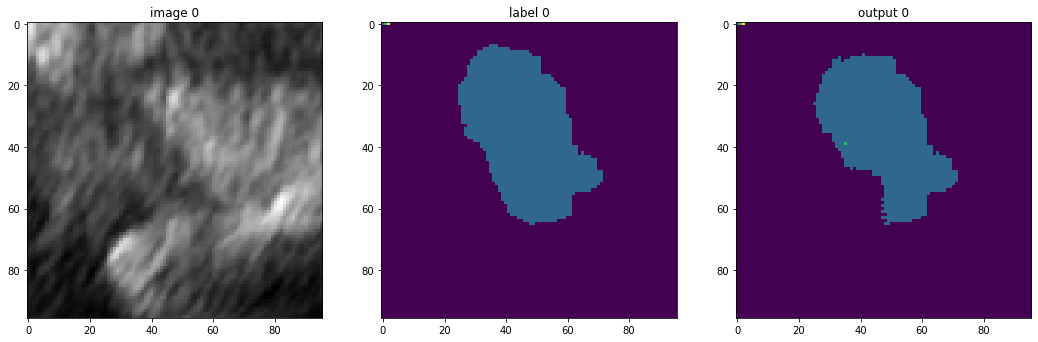

219ns_image_1884162273498_clean_ClassN_7-103.roi.mha


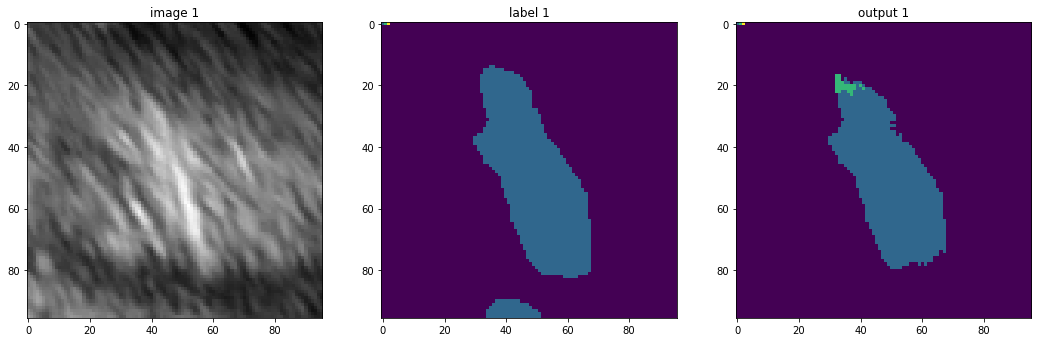

219ns_image_1884162273498_clean_ClassN_93-189.roi.mha


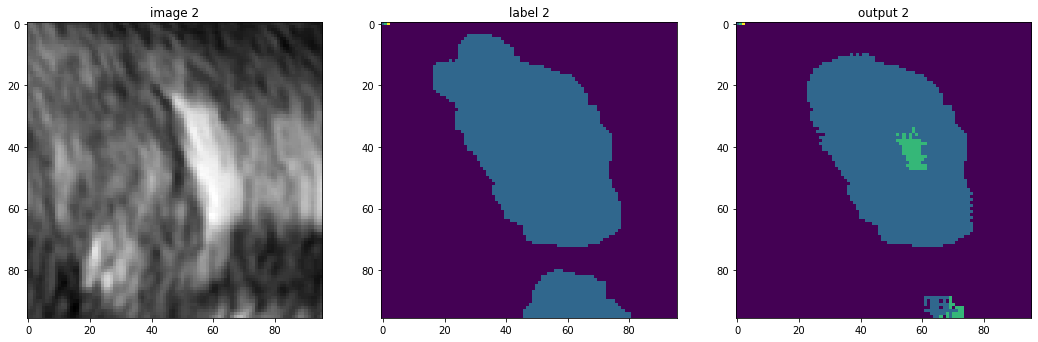

219ns_image_1895283541879_clean_ClassN_0-96.roi.mha


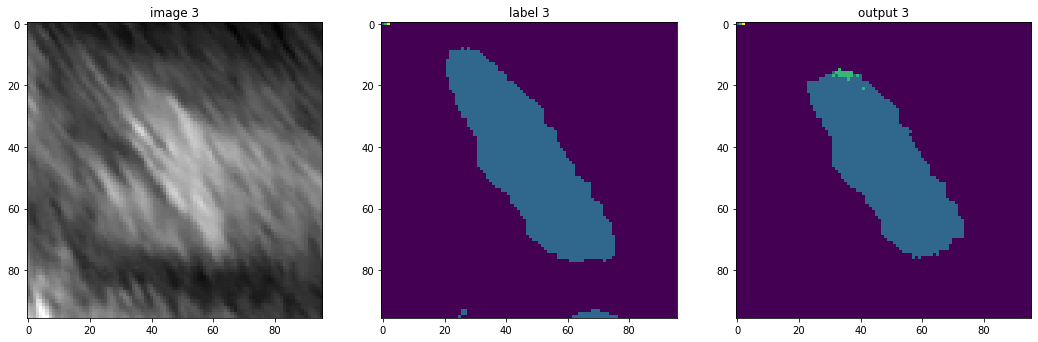

219ns_image_1895283541879_clean_ClassN_158-254.roi.mha


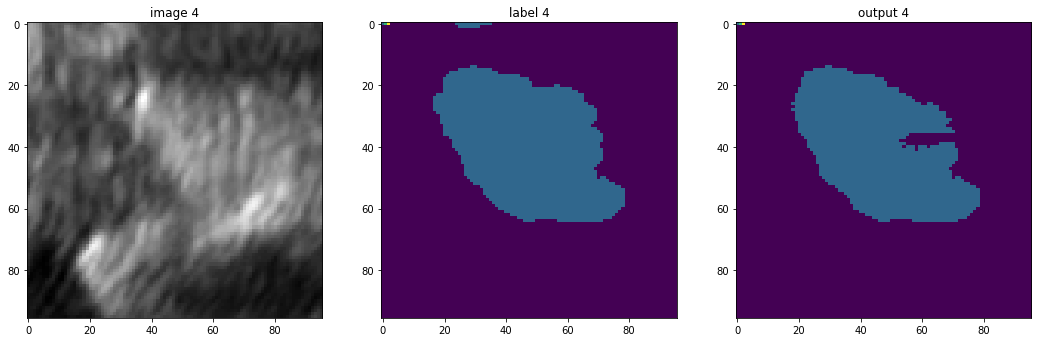

219ns_image_1895283541879_clean_ClassN_92-188.roi.mha


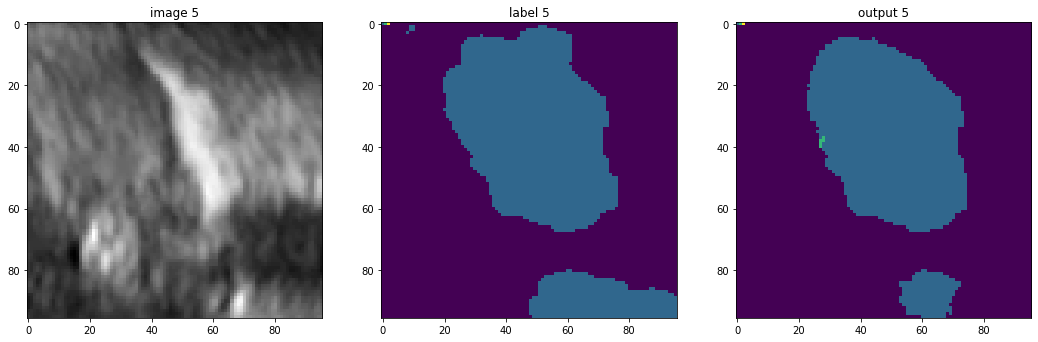

219n Counts per class =  6 0
  Winner = NOT Sliding


221ns_image_584357289931_clean_ClassN_144-240.roi.mha


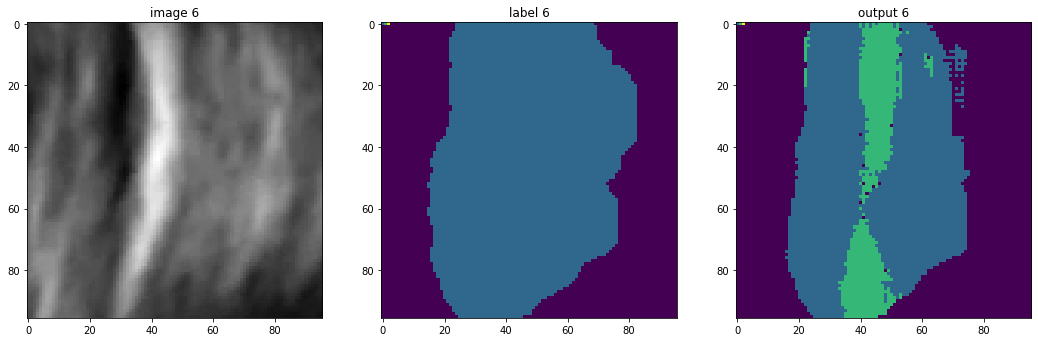

221ns_image_588695055398_clean_ClassN_148-244.roi.mha


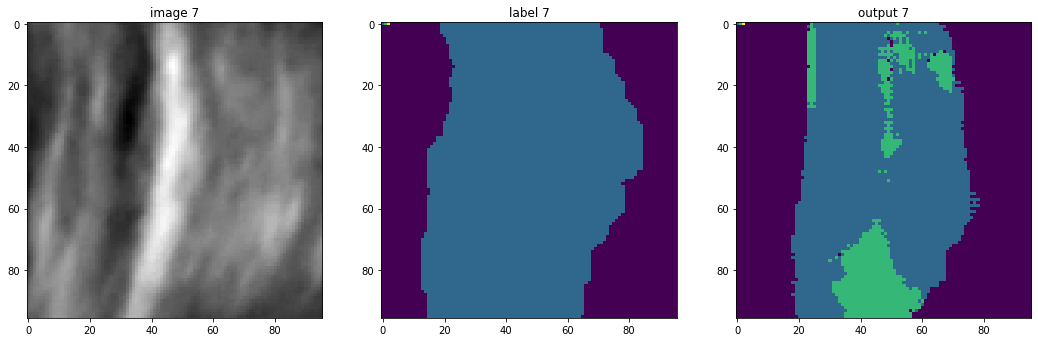

221n Counts per class =  2 0
  Winner = NOT Sliding


224s_iimage_3308406916756_clean_ClassS_162-258.roi.mha


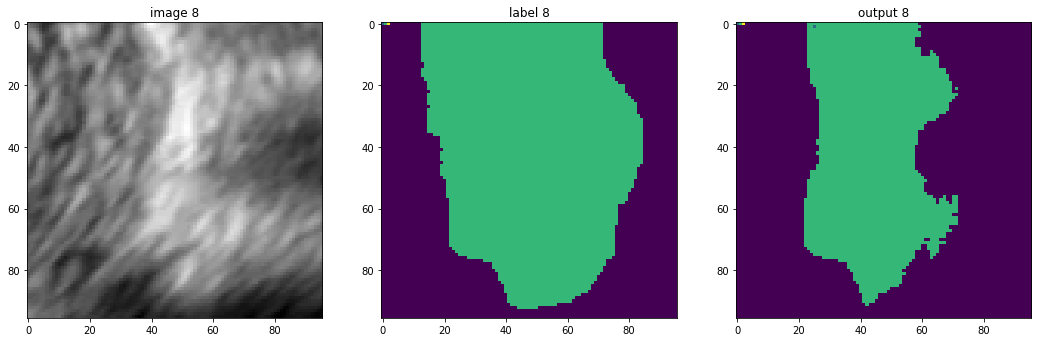

224s_iimage_3315947589826_clean_ClassS_144-240.roi.mha


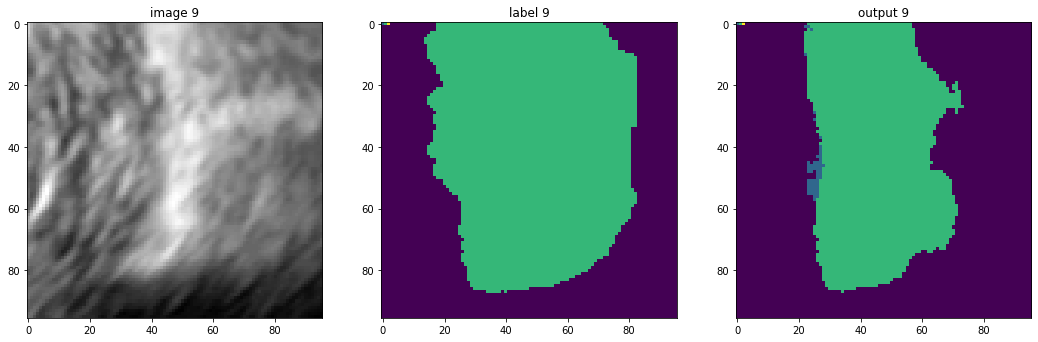

224s Counts per class =  0 2
  Winner = Sliding


228s_iimage_3321463845606_clean_ClassS_224-320.roi.mha


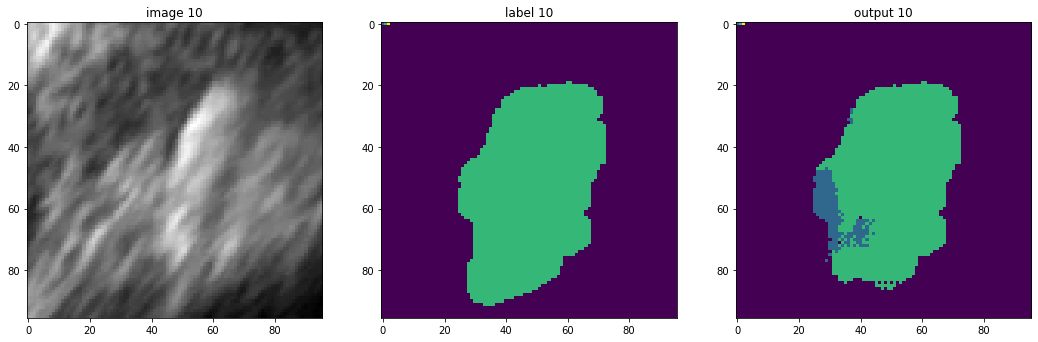

228s_iimage_3321463845606_clean_ClassS_60-156.roi.mha


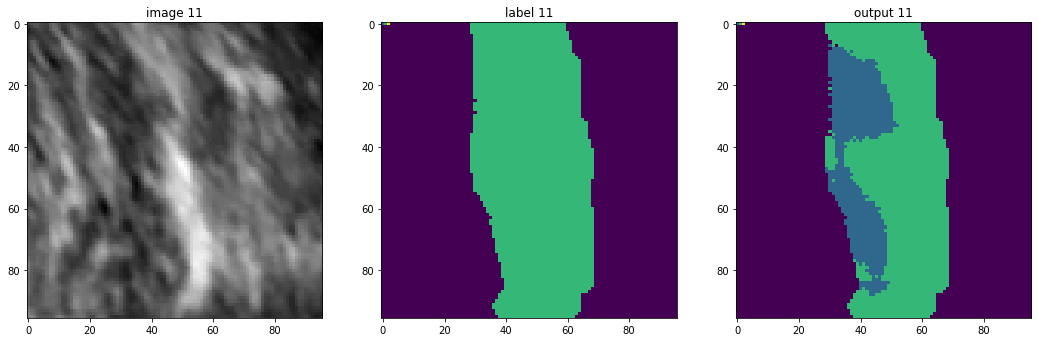

228s_iimage_3384882513134_clean_ClassS_164-260.roi.mha


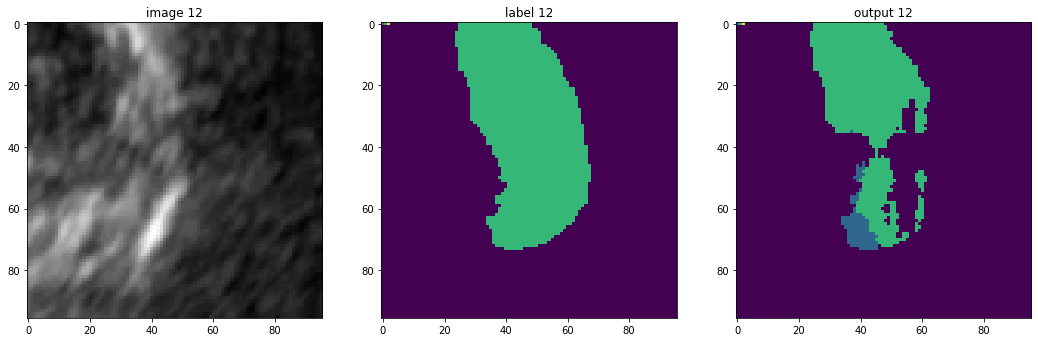

228s_iimage_3384882513134_clean_ClassS_69-165.roi.mha


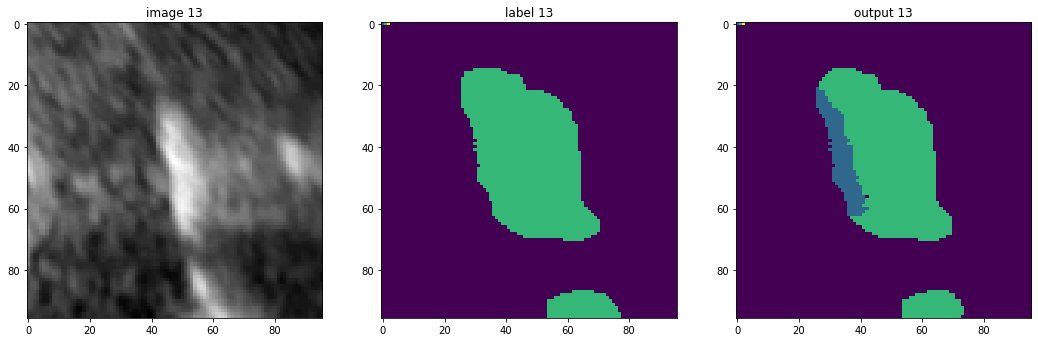

228s Counts per class =  0 4
  Winner = Sliding


23 8


In [67]:
correct = 0
incorrect = 0
for i in range(num_folds):
    (fcorrect, fincorrect) = plot_vfold_training_curves(i, test_loader[i])
    correct += fcorrect
    incorrect += fincorrect
print(correct, incorrect)